### Qualitative Feature Selection

### **Balance Sheet (Table 1)**

1. **Cash (CH)** – Indicates immediate liquidity; firms with low cash reserves may struggle to meet short-term obligations
2. **Short-term Investments (IVST)** – Liquid assets that supplement cash and provide a buffer in downturns
3. **Accounts Receivable (RECT)** – High receivables may signal collection risk and strained cash flow
4. **Inventory (INVT)** – Excessive inventory ties up capital and may become obsolete in distress
5. **Property, Plant & Equipment (PPENT)** – Captures fixed asset base; illiquid but important for collateral
6. **Total Liabilities (LT)** – A measure of leverage and long-term obligations
7. **Shareholders’ Equity (SEQ)** – Represents financial cushion; erosion of equity signals distress

---

### **Cash Flow Statement (Table 2)**

8. **Operating Cash Flow (OANCF)** – Key measure of internal financing ability; persistent negative OCF signals distress
9. **Capital Expenditures (CAPX)** – Indicates investment intensity; high capex may strain liquidity
10. **Cash Dividends (DV)** – Dividend cuts often precede distress; useful as a predictor

---

### **Income Statement (Table 8)**

11. **Sales (SALE)** – Primary revenue indicator; declining sales often precede financial distress
12. **Cost of Goods Sold (COGS)** – Paired with sales to evaluate profitability and efficiency
13. **Operating Income Before Depreciation (OIBDP)** – Reflects profitability from operations
14. **Net Income (NI)** – Bottom-line profitability; negative NI is strongly associated with bankruptcy risk
15. **Interest Expense (XINT)** – Captures debt servicing burden; high relative to income signals risk

---

### **Financial Ratios (Table 9 & 10)**

16. **Current Ratio (ACT/LCT)** – Liquidity measure; ability to cover short-term obligations
17. **Quick Ratio ((ACT–INVT)/LCT)** – Stricter liquidity test excluding inventories
18. **Debt-to-Assets (DLTT+LCT)/AT** – Solvency measure; higher values increase bankruptcy likelihood
19. **Debt-to-Equity (DLTT/SEQ)** – Capital structure balance; excessive leverage raises risk
20. **Return on Assets (NI/AT)** – Profitability relative to asset base; declining ROA indicates inefficiency
21. **Asset Turnover (SALE/AT)** – Efficiency ratio; weak turnover suggests poor utilization of assets
22. **Operating Cash Flow to Debt (OANCF/TOTAL\_DEBT)** – Cash-based solvency measure, robust to accounting choices

In [32]:
import os
import numpy as np
import pandas as pd

In [33]:
DATA_PATH = "./data"
CSV_FILE  = "COMPUSTAT_funda_annual.csv"   
YEAR_MIN, YEAR_MAX = 1996, 2022

TARGETS = {
    
    "CHE": ["CHE","CH","CASH"],  
    "IVST": ["IVST","IVT","STINV"],
    "RECT": ["RECT","RECCH","RECEIV"],
    "INVT": ["INVT","INVTRY","INVENT"],
    "PPENT": ["PPENT","PPEGT","NETPPE"],
    "LT": ["LT","LTTOT","TOTLIAB"],
    "SEQ": ["SEQ","SEQQ","STKQ","TSE","BOOKEQ","CEQ"],  
    "CEQ": ["CEQ"],  

    "OANCF": ["OANCF","NOCF","CFO"],
    "CAPX": ["CAPX","CAPEX"],
    "DV": ["DV","DVT","DVC","DVD"],  

    "SALE": ["SALE","REVT","SALES"],
    "COGS": ["COGS"],
    "OIBDP": ["OIBDP","EBITDA","OPINCDP"],
    "NI": ["NI","NICON","NIX"],  
    "XINT": ["XINT","INTEXP"],
    
    "AT": ["AT","ASSETS","TA"],
    "DLTT": ["DLTT","LTDEBT"],
    "DLC": ["DLC","STD","DEBTST"],
    "ACT": ["ACT","CA"],
    "LCT": ["LCT","CL"],
    
    "GVKEY": ["GVKEY","gvkey"],
    "FYEAR": ["FYEAR","fyear","YEAR","year"],
}

In [34]:
csv_path = os.path.join(DATA_PATH, CSV_FILE)
hdr = pd.read_csv(csv_path, nrows=0, low_memory=False)
avail_cols = {c.upper(): c for c in hdr.columns}  

def find_first(alternatives):
    for alt in alternatives:
        if alt.upper() in avail_cols:
            return avail_cols[alt.upper()]
    return None

actual_to_mnemonic = {}
missing_targets = []
for mnemonic, alts in TARGETS.items():
    actual = find_first(alts)
    if actual:
        actual_to_mnemonic[actual] = mnemonic
    else:
        missing_targets.append(mnemonic)

if "DV" in TARGETS:
    dvc_actual = find_first(["DVC"])
    dv_actual  = find_first(["DV","DVT","DVD"])
    if dvc_actual:
        actual_to_mnemonic[dvc_actual] = "DV"
        to_del = [k for k,v in actual_to_mnemonic.items() if v == "DV" and k != dvc_actual]
        for k in to_del: del actual_to_mnemonic[k]
    elif dv_actual:
        actual_to_mnemonic[dv_actual] = "DV"

usecols = list(actual_to_mnemonic.keys())
if not usecols:
    raise RuntimeError("None of the expected columns were found. Check CSV header.")

In [35]:
df = pd.read_csv(csv_path, usecols=usecols, low_memory=False)
df = df.rename(columns=actual_to_mnemonic)

if "GVKEY" not in df.columns or "FYEAR" not in df.columns:
    raise RuntimeError("GVKEY and/or FYEAR not found in the CSV (after mapping).")

In [36]:
df = df[(df["FYEAR"] >= YEAR_MIN) & (df["FYEAR"] <= YEAR_MAX)].copy()
to_num = [c for c in [
    "CHE","IVST","RECT","INVT","PPENT","LT","SEQ","CEQ",
    "OANCF","CAPX","DV","SALE","COGS","OIBDP","NI","XINT",
    "AT","DLTT","DLC","ACT","LCT"
] if c in df.columns]

df[to_num] = df[to_num].apply(pd.to_numeric, errors="coerce")
if "SEQ" not in df.columns and "CEQ" in df.columns:
    df["SEQ"] = df["CEQ"]

total_debt   = df.get("DLTT", 0).fillna(0) + df.get("DLC", 0).fillna(0)
quick_assets = df.get("ACT", pd.Series(np.nan, index=df.index)) - df.get("INVT", 0).fillna(0)

df_out = df[["GVKEY","FYEAR"]].copy()

df_out["cash"] = df.get("CHE")
df_out["short_term_investments"] = df.get("IVST")
df_out["accounts_receivable"] = df.get("RECT")
df_out["inventory"] = df.get("INVT")
df_out["ppe_net"] = df.get("PPENT")
df_out["total_liabilities"] = df.get("LT")
df_out["shareholders_equity"] = df.get("SEQ")

df_out["operating_cf"] = df.get("OANCF")
df_out["capex"] = df.get("CAPX")
df_out["dividends"] = df.get("DV")

df_out["sales"] = df.get("SALE")
df_out["cogs"] = df.get("COGS")
df_out["oibdp"] = df.get("OIBDP")
df_out["net_income"] = df.get("NI")
df_out["interest_expense"] = df.get("XINT")

def sdiv(num, den):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    out = num.div(den)
    return out.where(den != 0)

den_lct = df.get("LCT")
den_at  = df.get("AT")
den_seq = df.get("SEQ")

df_out["current_ratio"]  = sdiv(df.get("ACT"), den_lct)
df_out["quick_ratio"]    = sdiv(quick_assets, den_lct)
df_out["debt_to_assets"] = sdiv(total_debt, den_at)
df_out["debt_to_equity"] = sdiv(total_debt, den_seq)
df_out["roa"]            = sdiv(df.get("NI"), den_at)
df_out["asset_turnover"] = sdiv(df.get("SALE"), den_at)
df_out["ocf_to_debt"]    = sdiv(df.get("OANCF"), total_debt)

print("Loaded columns mapped ->", {v:k for k,v in actual_to_mnemonic.items()})
if missing_targets:
    print("Not in file (ok if unused):", sorted(missing_targets))

print("Shape:", df_out.shape)
print(df_out.head())

out_path_csv = os.path.join(DATA_PATH, "selected_features_1996_2022.csv")
df_out.to_csv(out_path_csv, index=False)
print("Saved:", out_path_csv)


Loaded columns mapped -> {'CHE': 'che', 'IVST': 'ivst', 'RECT': 'rect', 'INVT': 'invt', 'PPENT': 'ppent', 'LT': 'lt', 'SEQ': 'seq', 'CEQ': 'ceq', 'OANCF': 'oancf', 'CAPX': 'capx', 'SALE': 'sale', 'COGS': 'cogs', 'OIBDP': 'oibdp', 'NI': 'ni', 'XINT': 'xint', 'AT': 'at', 'DLTT': 'dltt', 'DLC': 'dlc', 'ACT': 'act', 'LCT': 'lct', 'GVKEY': 'gvkey', 'FYEAR': 'fyear', 'DV': 'dvc'}
Shape: (295612, 24)
    GVKEY  FYEAR    cash  short_term_investments  accounts_receivable  \
79   1004   1996  51.705                     0.0              122.944   
80   1004   1997  17.222                     0.0              163.359   
81   1004   1998   8.250                     0.0              164.302   
82   1004   1999   1.241                     0.0              128.348   
83   1004   2000  13.809                     0.0              115.187   

    inventory  ppe_net  total_liabilities  shareholders_equity  operating_cf  \
79    217.239   71.108            260.325              269.259         9.531   
80  

In [37]:
SEL_FILE  = os.path.join(DATA_PATH, "selected_features_1996_2022.csv")

if "df_out" in globals():
    feats = df_out.copy()
else:
    feats = pd.read_csv(SEL_FILE)

numeric_cols = [c for c in feats.columns if c not in ("GVKEY","FYEAR")]
feats[numeric_cols] = feats[numeric_cols].apply(pd.to_numeric, errors="coerce")

feature_cols = [
    "cash","short_term_investments","accounts_receivable","inventory","ppe_net",
    "total_liabilities","shareholders_equity","operating_cf","capex","dividends",
    "sales","cogs","oibdp","net_income","interest_expense",
    "current_ratio","quick_ratio","debt_to_assets","debt_to_equity","roa","asset_turnover",
    "ocf_to_debt"
]
feature_cols = [c for c in feature_cols if c in feats.columns]

In [38]:
def get_usrec_annual(data_path="./data"):
    try:
        from fredapi import Fred
        fred = Fred()  
        ser = fred.get_series("USREC")  
        m = ser.to_frame("USREC").reset_index().rename(columns={"index": "DATE"})
        m["FYEAR"] = m["DATE"].dt.year
        annual = m.groupby("FYEAR", as_index=False)["USREC"].max()
        return annual.rename(columns={"USREC": "USREC_ANNUAL"})
    except Exception:
        csv_path = os.path.join(data_path, "USREC.csv")
        if not os.path.exists(csv_path):
            fallback = pd.DataFrame({"FYEAR": list(range(1996, 2023))})
            fallback["USREC_ANNUAL"] = fallback["FYEAR"].isin([2001, 2008, 2009, 2020]).astype(int)
            return fallback
        m = pd.read_csv(csv_path, parse_dates=["DATE"])
        m["FYEAR"] = m["DATE"].dt.year
        annual = m.groupby("FYEAR", as_index=False)["USREC"].max()
        return annual.rename(columns={"USREC": "USREC_ANNUAL"})

usrec = get_usrec_annual(DATA_PATH)
feats = feats.merge(usrec, on="FYEAR", how="left")
feats_nonan = feats.dropna(subset=feature_cols, how="all").copy()

In [39]:
corr_all = feats_nonan[feature_cols].corr()
corr_rec = feats_nonan.loc[feats_nonan["USREC_ANNUAL"] == 1, feature_cols].corr()
corr_non = feats_nonan.loc[feats_nonan["USREC_ANNUAL"] == 0, feature_cols].corr()

out_dir = os.path.join(DATA_PATH, "as3_corr_outputs")
os.makedirs(out_dir, exist_ok=True)
corr_all.to_csv(os.path.join(out_dir, "corr_all.csv"))
corr_rec.to_csv(os.path.join(out_dir, "corr_recession.csv"))
corr_non.to_csv(os.path.join(out_dir, "corr_expansion.csv"))
print(f"Saved correlation matrices to: {out_dir}")

Saved correlation matrices to: ./data/as3_corr_outputs


In [40]:
def high_corr_pairs(corr, thresh=0.90):
    pairs = []
    cols = corr.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr.iloc[i, j]
            if pd.notna(val) and abs(val) >= thresh:
                pairs.append((cols[i], cols[j], float(val)))
    pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    return pairs

pairs_high = high_corr_pairs(corr_all, thresh=0.90)
print("\nTop highly correlated pairs (|r| >= 0.90):")
for a,b,v in pairs_high[:15]:
    print(f"{a:22s} ~ {b:22s}: r = {v:.3f}")

priority = {
    "ocf_to_debt": 100, "quick_ratio": 95, "current_ratio": 90,
    "debt_to_assets": 90, "debt_to_equity": 80,
    "roa": 95, "asset_turnover": 90,
    "cash": 85, "operating_cf": 80,    
    "total_liabilities": 75, "shareholders_equity": 70,
    "inventory": 70, "accounts_receivable": 70, "ppe_net": 65,
    "dividends": 60, "interest_expense": 60, "capex": 60,
    "sales": 50, "cogs": 50, "oibdp": 50, "net_income": 50,
}

def pick_drop_list(pairs, priority):
    drops = set()
    kept = set()
    for a,b,_ in pairs:
        if a in drops or b in drops: 
            continue
        pa = priority.get(a, 60)
        pb = priority.get(b, 60)
        if pa >= pb:
            kept.add(a); drops.add(b)
        else:
            kept.add(b); drops.add(a)
    return sorted(drops), sorted(kept)

suggested_drops, kept = pick_drop_list(pairs_high, priority)
print("\nSuggested drops (due to high collinearity):")
print(suggested_drops)


Top highly correlated pairs (|r| >= 0.90):
current_ratio          ~ quick_ratio           : r = 1.000
sales                  ~ cogs                  : r = 0.968
cash                   ~ short_term_investments: r = 0.909

Suggested drops (due to high collinearity):
['cogs', 'current_ratio', 'short_term_investments']


In [41]:
corr_rec_al = corr_rec.reindex(index=feature_cols, columns=feature_cols)
corr_non_al = corr_non.reindex(index=feature_cols, columns=feature_cols)
corr_diff = corr_rec_al - corr_non_al

rows = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        a, b = feature_cols[i], feature_cols[j]
        d = corr_diff.loc[a, b]
        if pd.notna(d):
            rows.append((a, b, float(d)))
diff_df = pd.DataFrame(rows, columns=["var_a","var_b","delta_r"]).sort_values("delta_r", ascending=False)

print("\nTop pairs that become MORE positively correlated in recessions (Δr):")
print(diff_df.head(10).to_string(index=False))

print("\nTop pairs that become MORE negatively correlated in recessions (Δr most negative):")
print(diff_df.tail(10).to_string(index=False))

diff_df.to_csv(os.path.join(out_dir, "corr_delta_rec_minus_non.csv"), index=False)


Top pairs that become MORE positively correlated in recessions (Δr):
              var_a            var_b  delta_r
               cash     operating_cf 0.170643
               cash interest_expense 0.138130
                roa   asset_turnover 0.127159
       operating_cf interest_expense 0.120920
shareholders_equity interest_expense 0.076822
          inventory interest_expense 0.075022
               cogs interest_expense 0.072841
          inventory     operating_cf 0.063914
              capex interest_expense 0.062271
accounts_receivable             cogs 0.061390

Top pairs that become MORE negatively correlated in recessions (Δr most negative):
              var_a            var_b   delta_r
               cash       net_income -0.179530
accounts_receivable       net_income -0.226085
               cogs       net_income -0.228971
            ppe_net       net_income -0.231822
              sales       net_income -0.236893
         net_income interest_expense -0.258102
          d

In [42]:
ratio_cols = [c for c in ["current_ratio","quick_ratio","debt_to_assets","debt_to_equity","roa","asset_turnover","ocf_to_debt"]
              if c in feature_cols]
corr_all_ratios = feats_nonan[ratio_cols].corr()
corr_all_ratios.to_csv(os.path.join(out_dir, "corr_all_ratios_only.csv"))
print("\nSaved ratios-only correlation matrix")


Saved ratios-only correlation matrix


## 1) Should we group the variables differently?

**Yes.** For modeling, it’s cleaner to separate **levels** (scale-driven) from **ratios** (scale-neutral), then group by economic role.

**Levels (size/structure)**
- **Liquidity:** `cash`, `short_term_investments`
- **Operating scale & costs:** `sales`, `cogs`, `oibdp`, `net_income`
- **Structure:** `accounts_receivable`, `inventory`, `ppe_net`, `total_liabilities`, `shareholders_equity`
- **Cash-flow levels:** `operating_cf`, `capex`, `dividends`, `interest_expense`

**Ratios (comparability across firms)**
- **Liquidity:** `quick_ratio` (and `current_ratio` if kept)
- **Leverage/Solvency:** `debt_to_assets`, `debt_to_equity`
- **Profitability:** `roa`
- **Efficiency/Activity:** `asset_turnover`
- **Cash-based solvency:** `ocf_to_debt`

Ratios carry the most portable signal for cross-sectional prediction (e.g., bankruptcy), while levels can be retained selectively to capture scale effects **only if** you truly need them.

---

## 2) What should we drop (and why)?

The top collinearity results:

- `current_ratio` ~ `quick_ratio` **r = 1.000** → **Drop** `current_ratio` 
  *Why:* Perfect duplication. Keep `quick_ratio` (stricter liquidity; excludes inventory).

- `sales` ~ `cogs` **r = 0.968** → **Drop** `cogs`
  *Why:* Costs scale with sales; the pair is near-duplicate. If you need profitability detail, compute a margin (e.g., `gross_margin = (sales - cogs)/sales`) instead of keeping both levels.

- `cash` ~ `short_term_investments` **r = 0.909** → **Drop** `short_term_investments`
  *Why:* Strongly overlapping liquidity buffers; often mechanically related to `cash`/`CHE`. Keep one measure (prefer `cash`). Optionally define **pure cash** as `CHE - IVST` and keep that single series.

---

## 3) Recession (USREC = 1) vs. Expansion (USREC = 0): What changed?

Using Δr = corr(recession) − corr(expansion) results:

**Correlations that tighten (become more positive) in recessions:**
- `cash` with `operating_cf` **(+0.171)** and with `interest_expense` **(+0.138)**  
  *Interpretation:* Under stress, firms with debt service needs keep tighter cash cushions; cash and cash generation move together more strongly.
- `roa` with `asset_turnover` **(+0.127)**  
  *Interpretation:* Operating efficiency is more tightly linked to profitability when conditions tighten.
- Wider linkages between operating/balance items and `interest_expense` (e.g., `inventory`, `shareholders_equity`, `cogs`) suggest leverage pressures show up more clearly across the statements during recessions.

**Correlations that weaken (more negative) in recessions:**
- `operating_cf` with `net_income` **(−0.305)**, and broadly **`net_income`** decouples from `sales`, `ppe_net`, `total_liabilities`, `shareholders_equity`, and `dividends`.  
  *Interpretation:* In downturns, accrual earnings diverge from cash reality (write-downs, accrual adjustments, dividend policy shifts), making **cash-based measures** relatively more informative.

**Modeling takeaway:** Emphasize **cash and robust ratios** (`ocf_to_debt`, `quick_ratio`, `debt_to_assets`, `roa`, `asset_turnover`) especially in stress regimes; de-emphasize redundant levels and highly collinear pairs.

In [43]:
import math
import matplotlib.pyplot as plt

IN_FILE   = os.path.join(DATA_PATH, "selected_features_1996_2022.csv")  
OUT_DIR   = os.path.join(DATA_PATH, "facet_histograms")
os.makedirs(OUT_DIR, exist_ok=True)

df_feats = pd.read_csv(IN_FILE)
df_feats["FYEAR"] = pd.to_numeric(df_feats["FYEAR"], errors="coerce")


feature_cols = [
    "cash","short_term_investments","accounts_receivable","inventory","ppe_net",
    "total_liabilities","shareholders_equity","operating_cf","capex","dividends",
    "sales","cogs","oibdp","net_income","interest_expense",
    "current_ratio","quick_ratio","debt_to_assets","debt_to_equity","roa","asset_turnover",
    "ocf_to_debt"
]
feature_cols = [c for c in feature_cols if c in df_feats.columns]


years = sorted(df_feats["FYEAR"].dropna().unique().astype(int))
years = [y for y in years if 1996 <= y <= 2022]

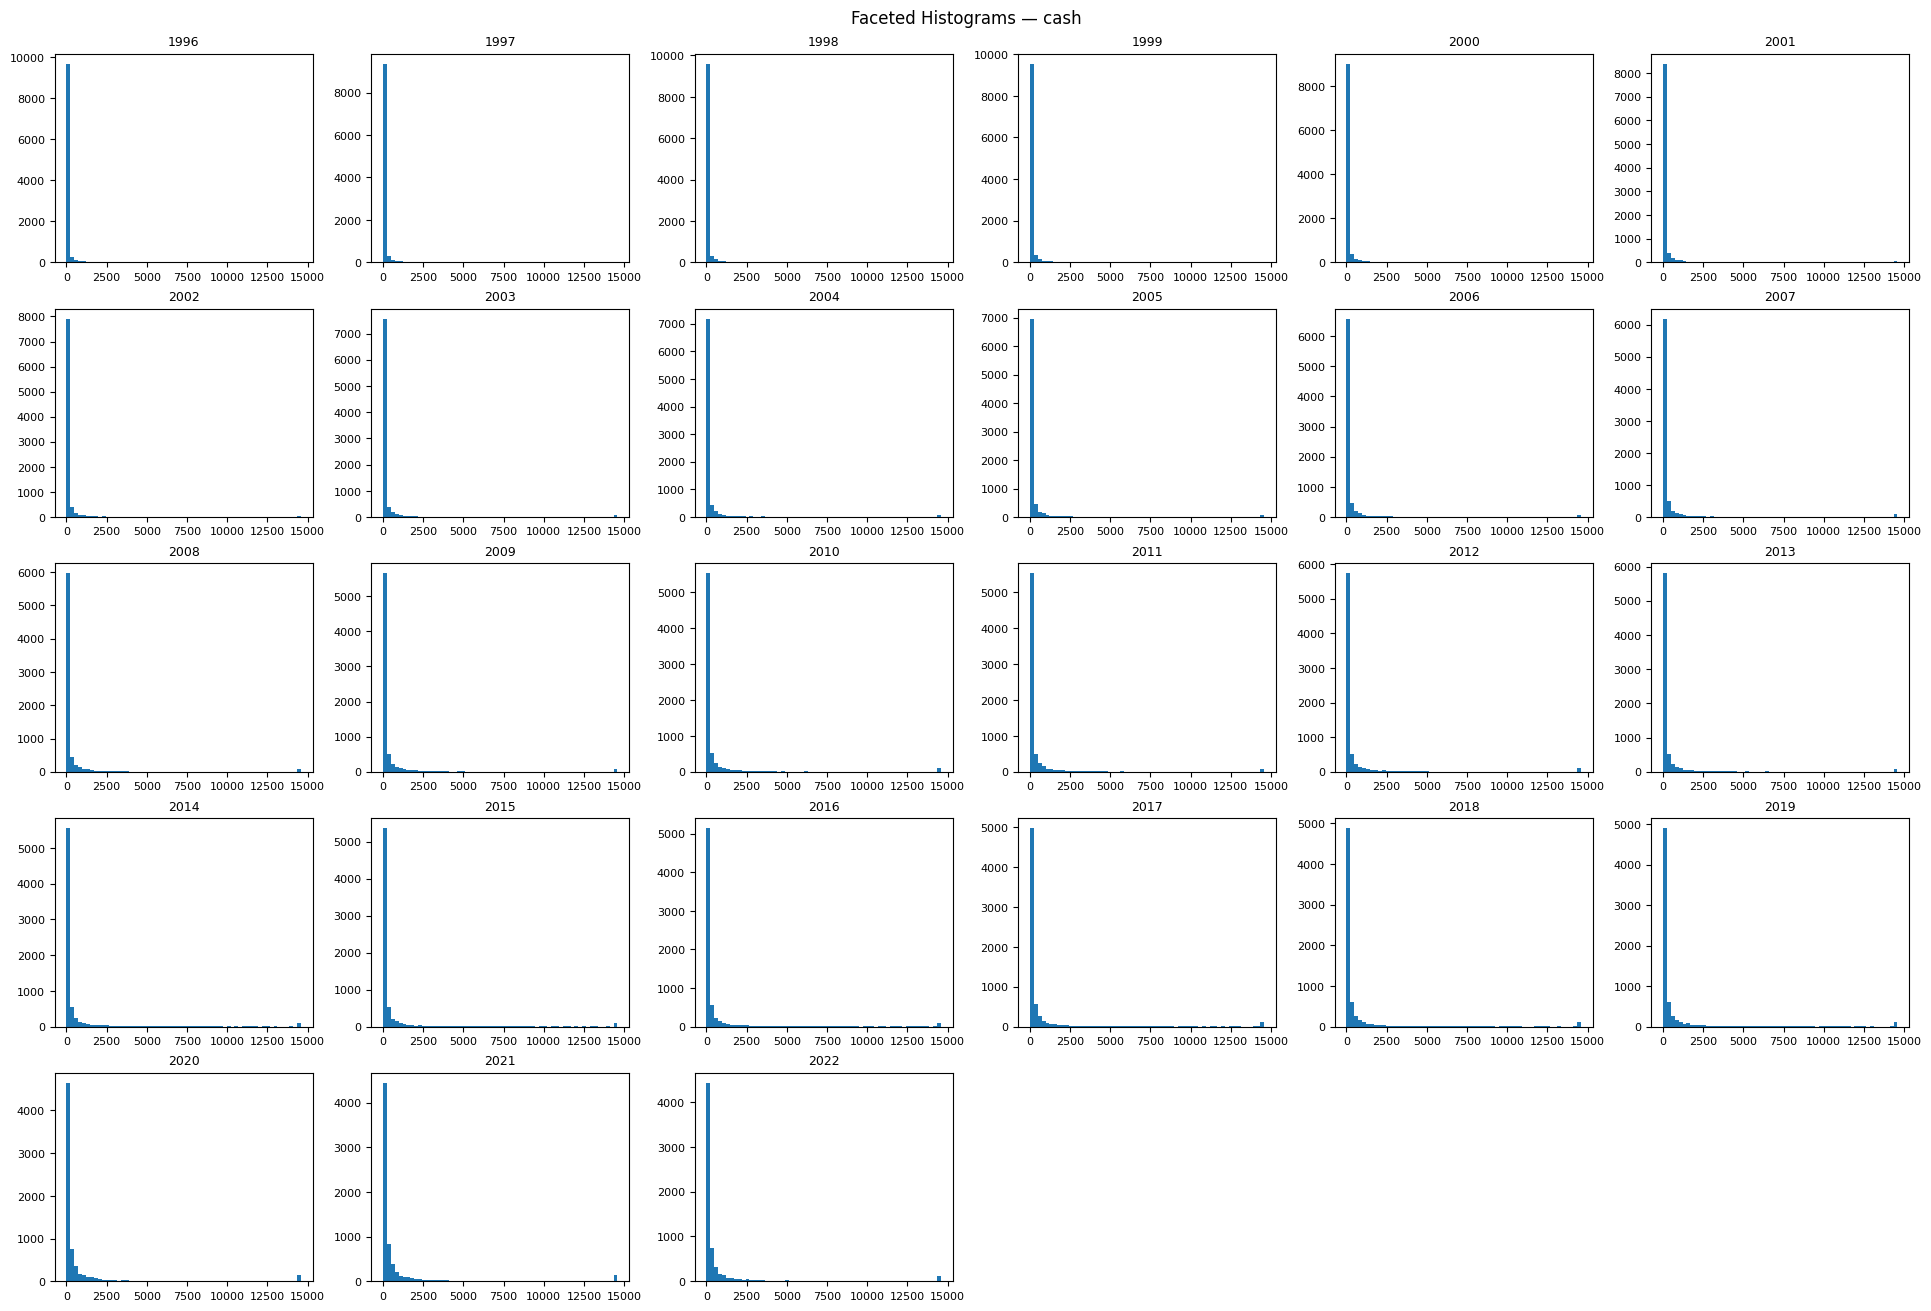

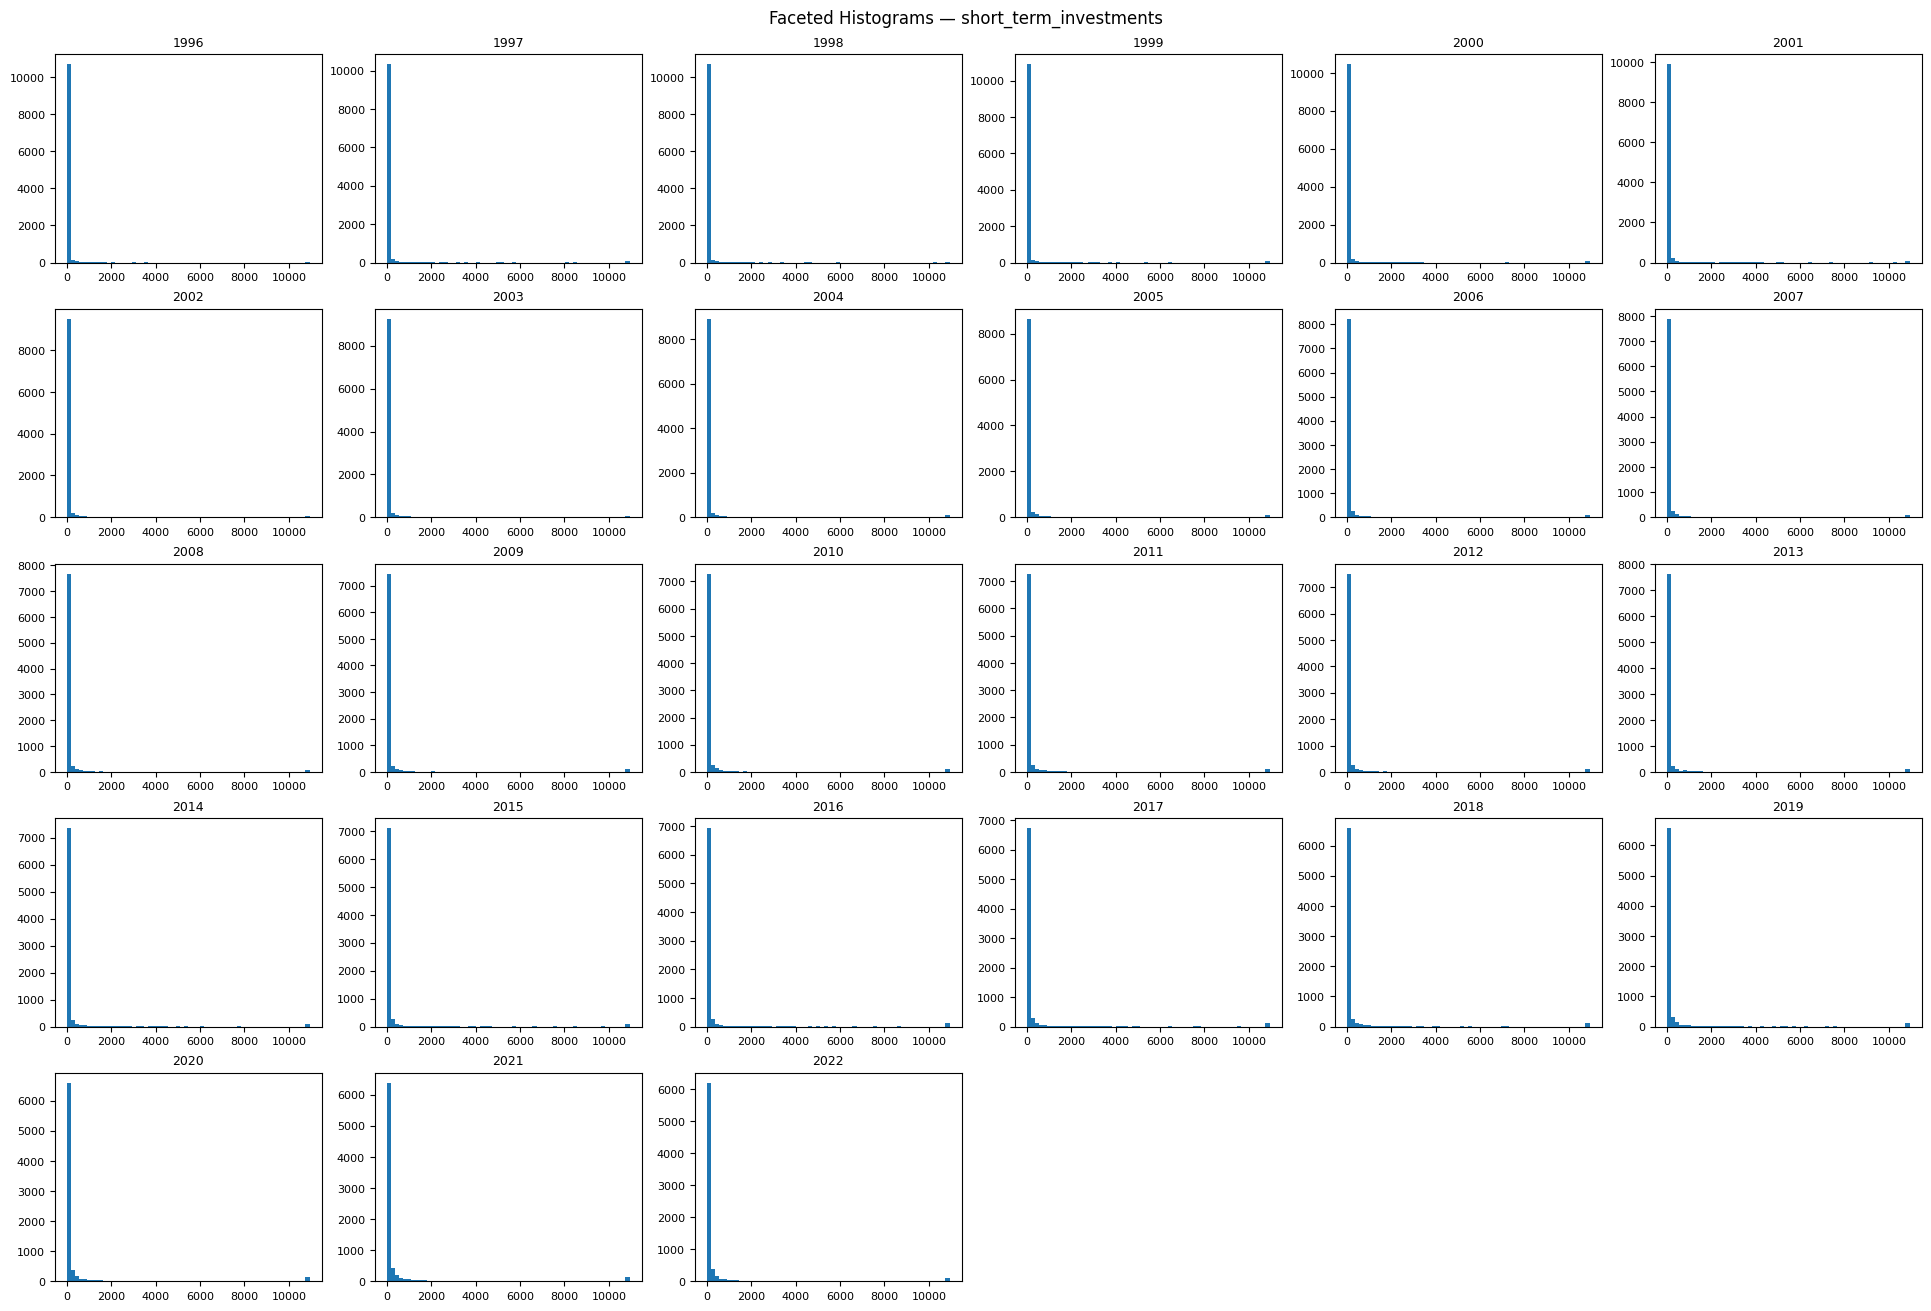

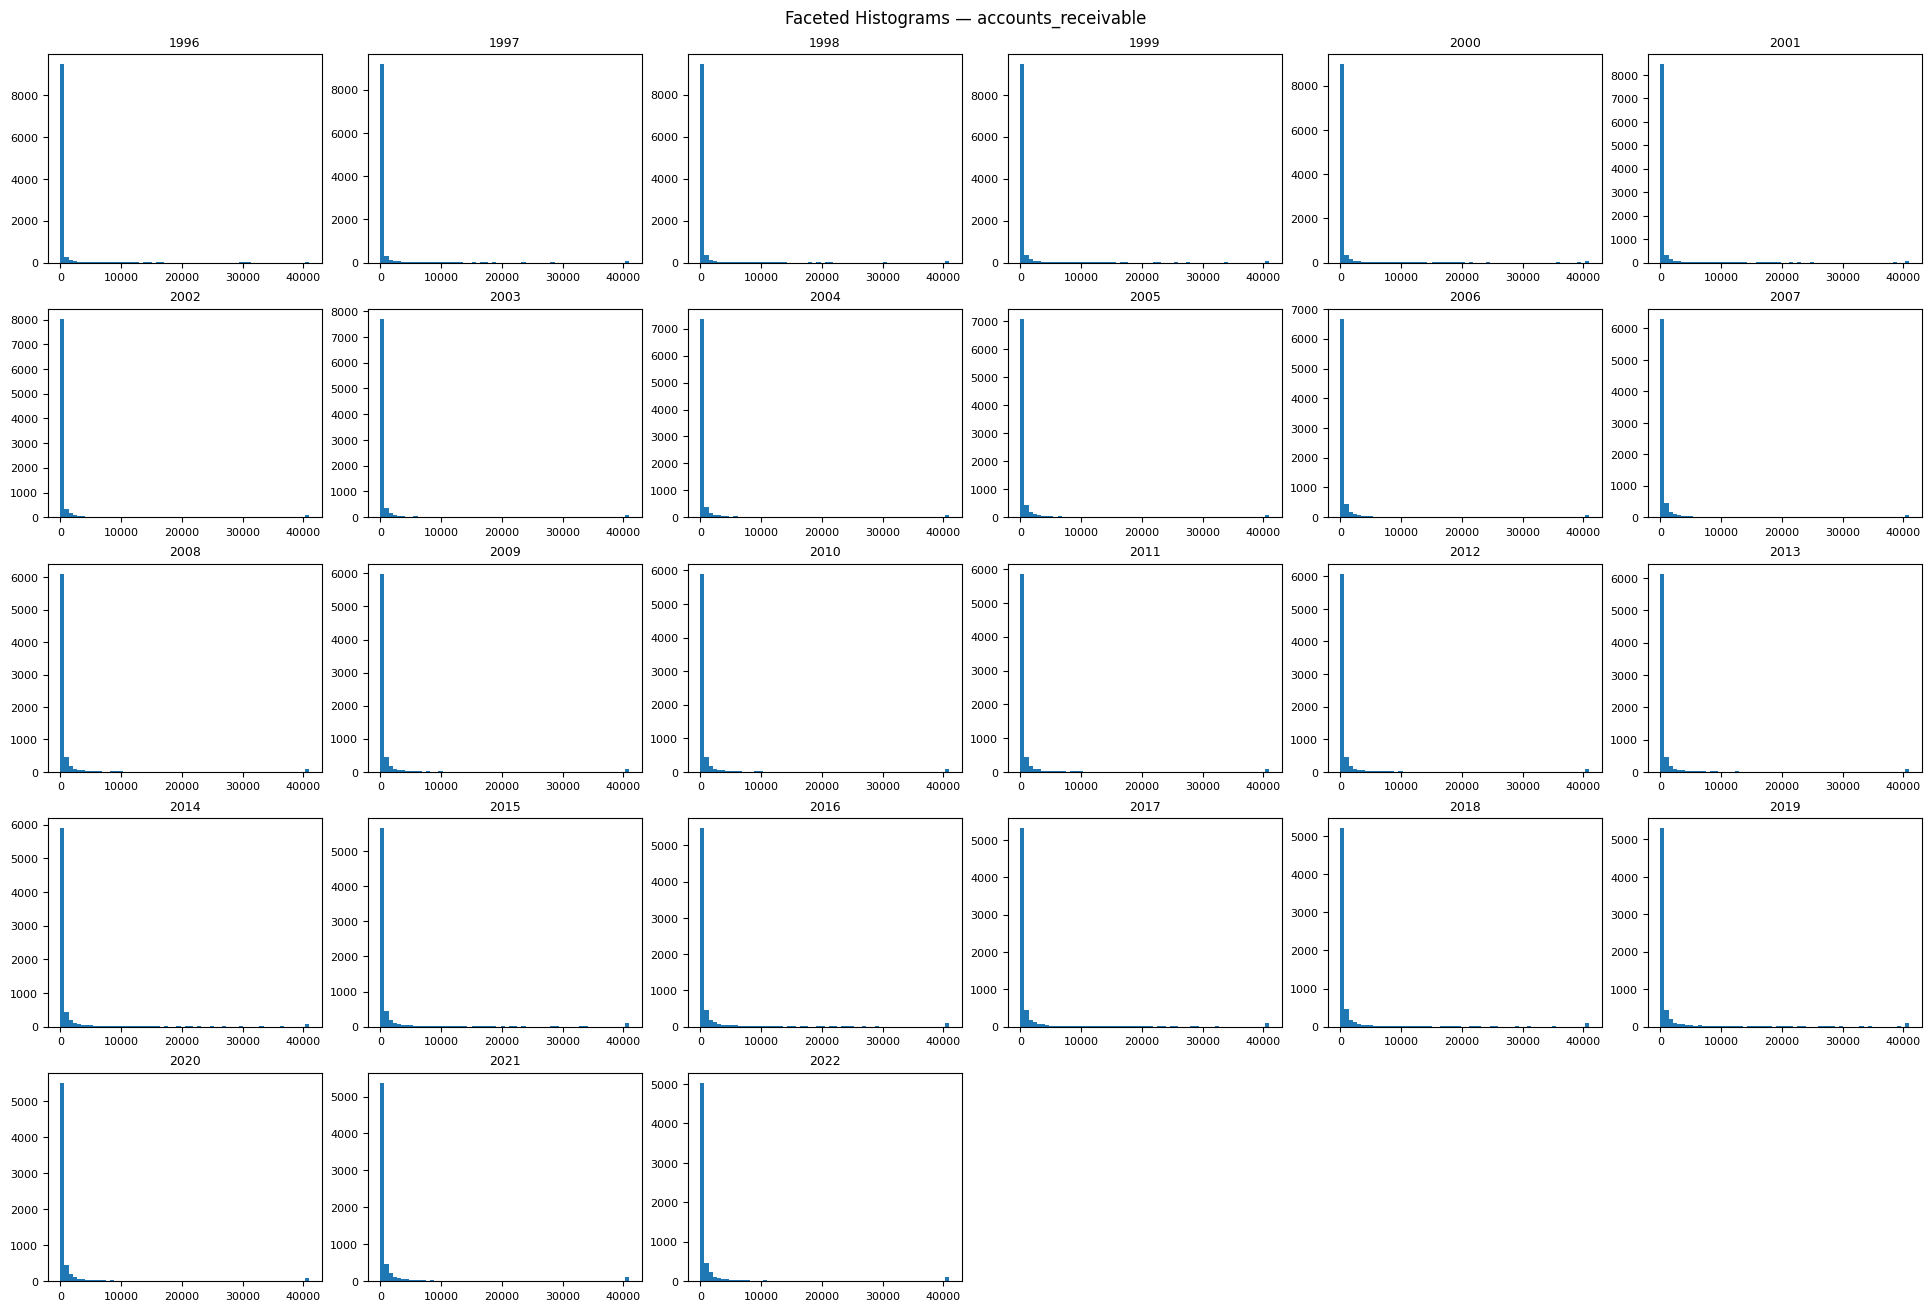

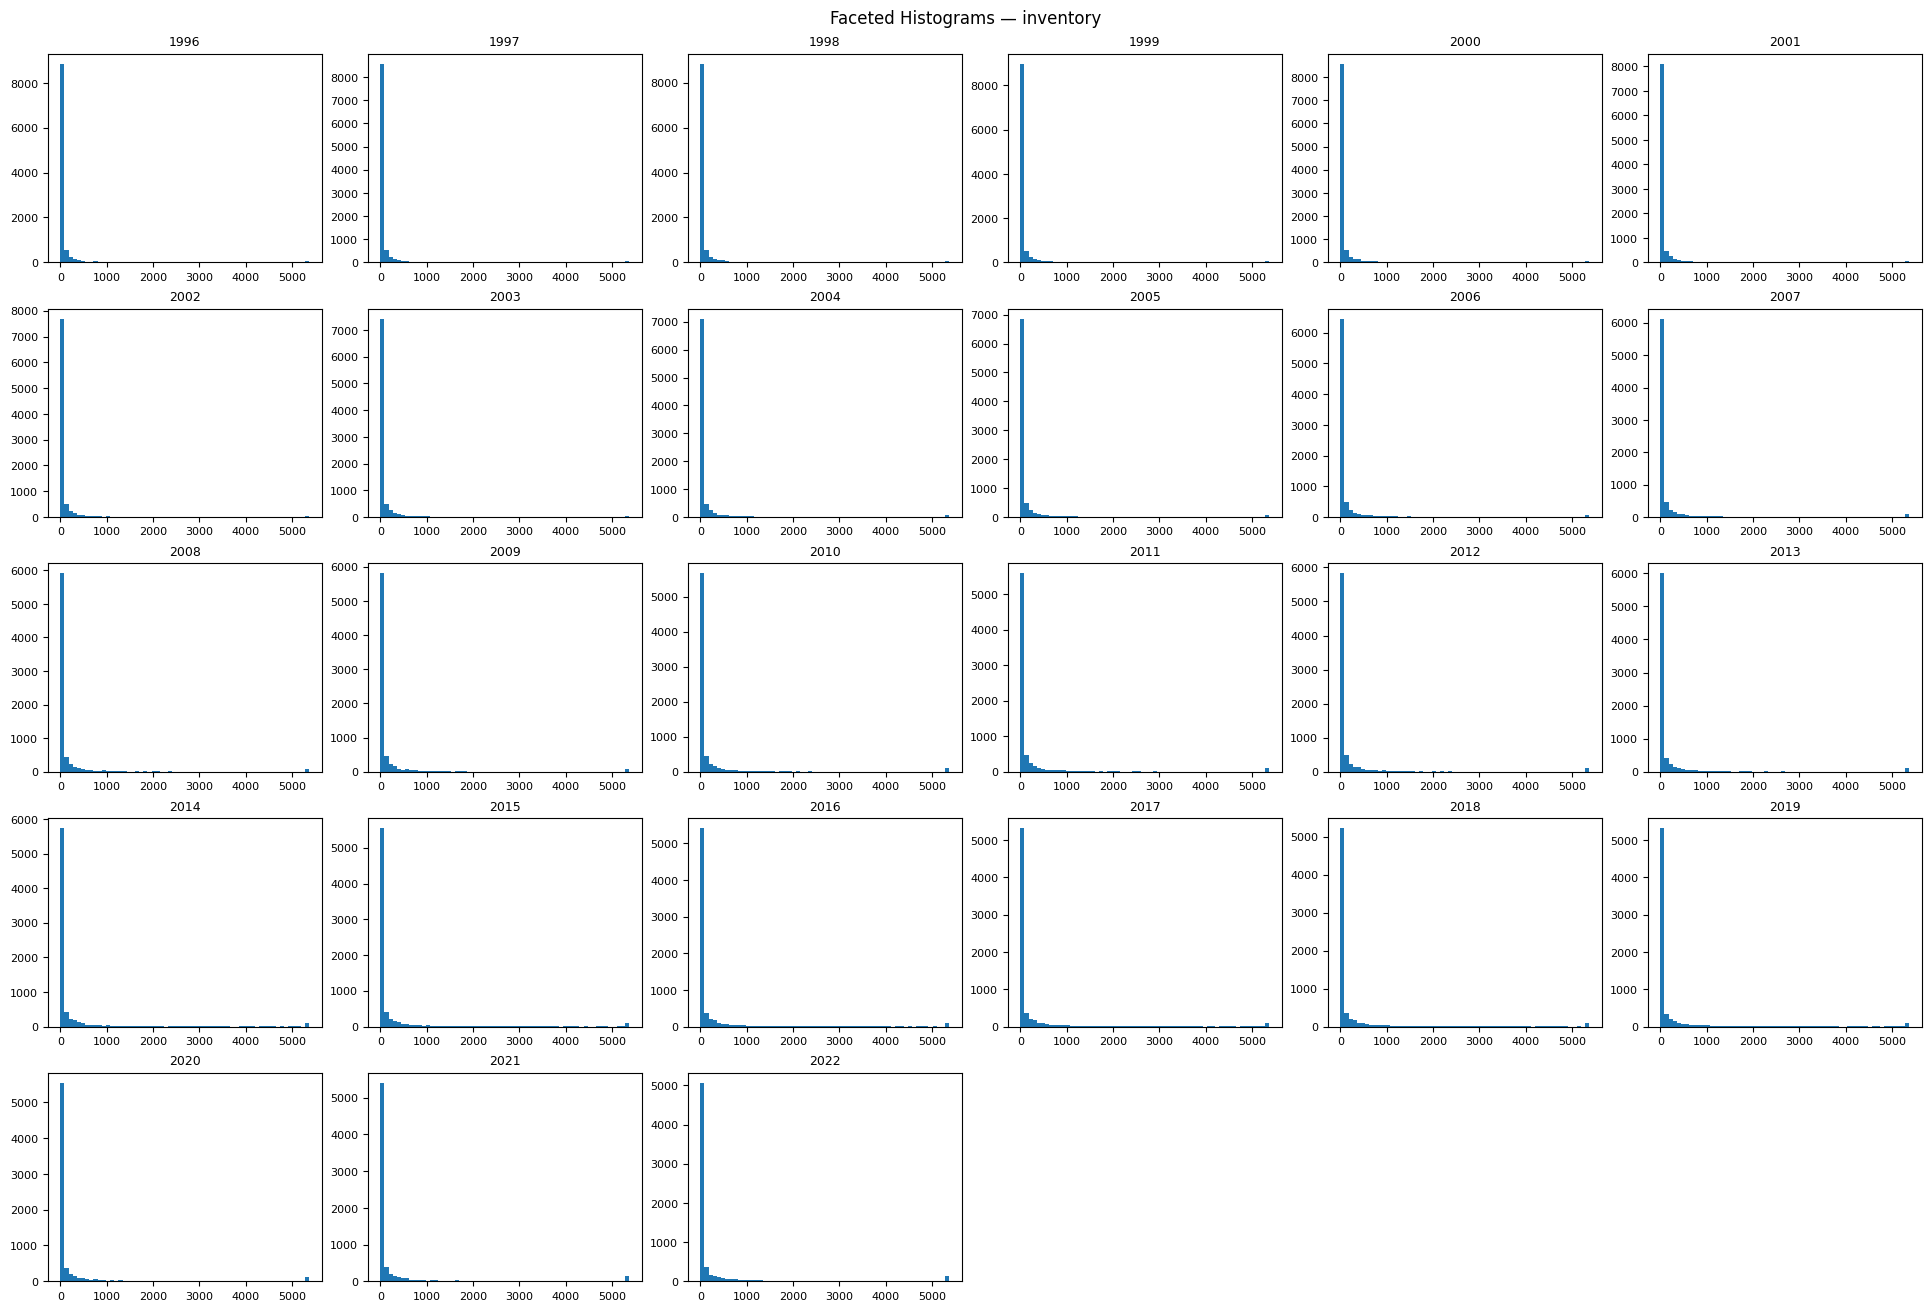

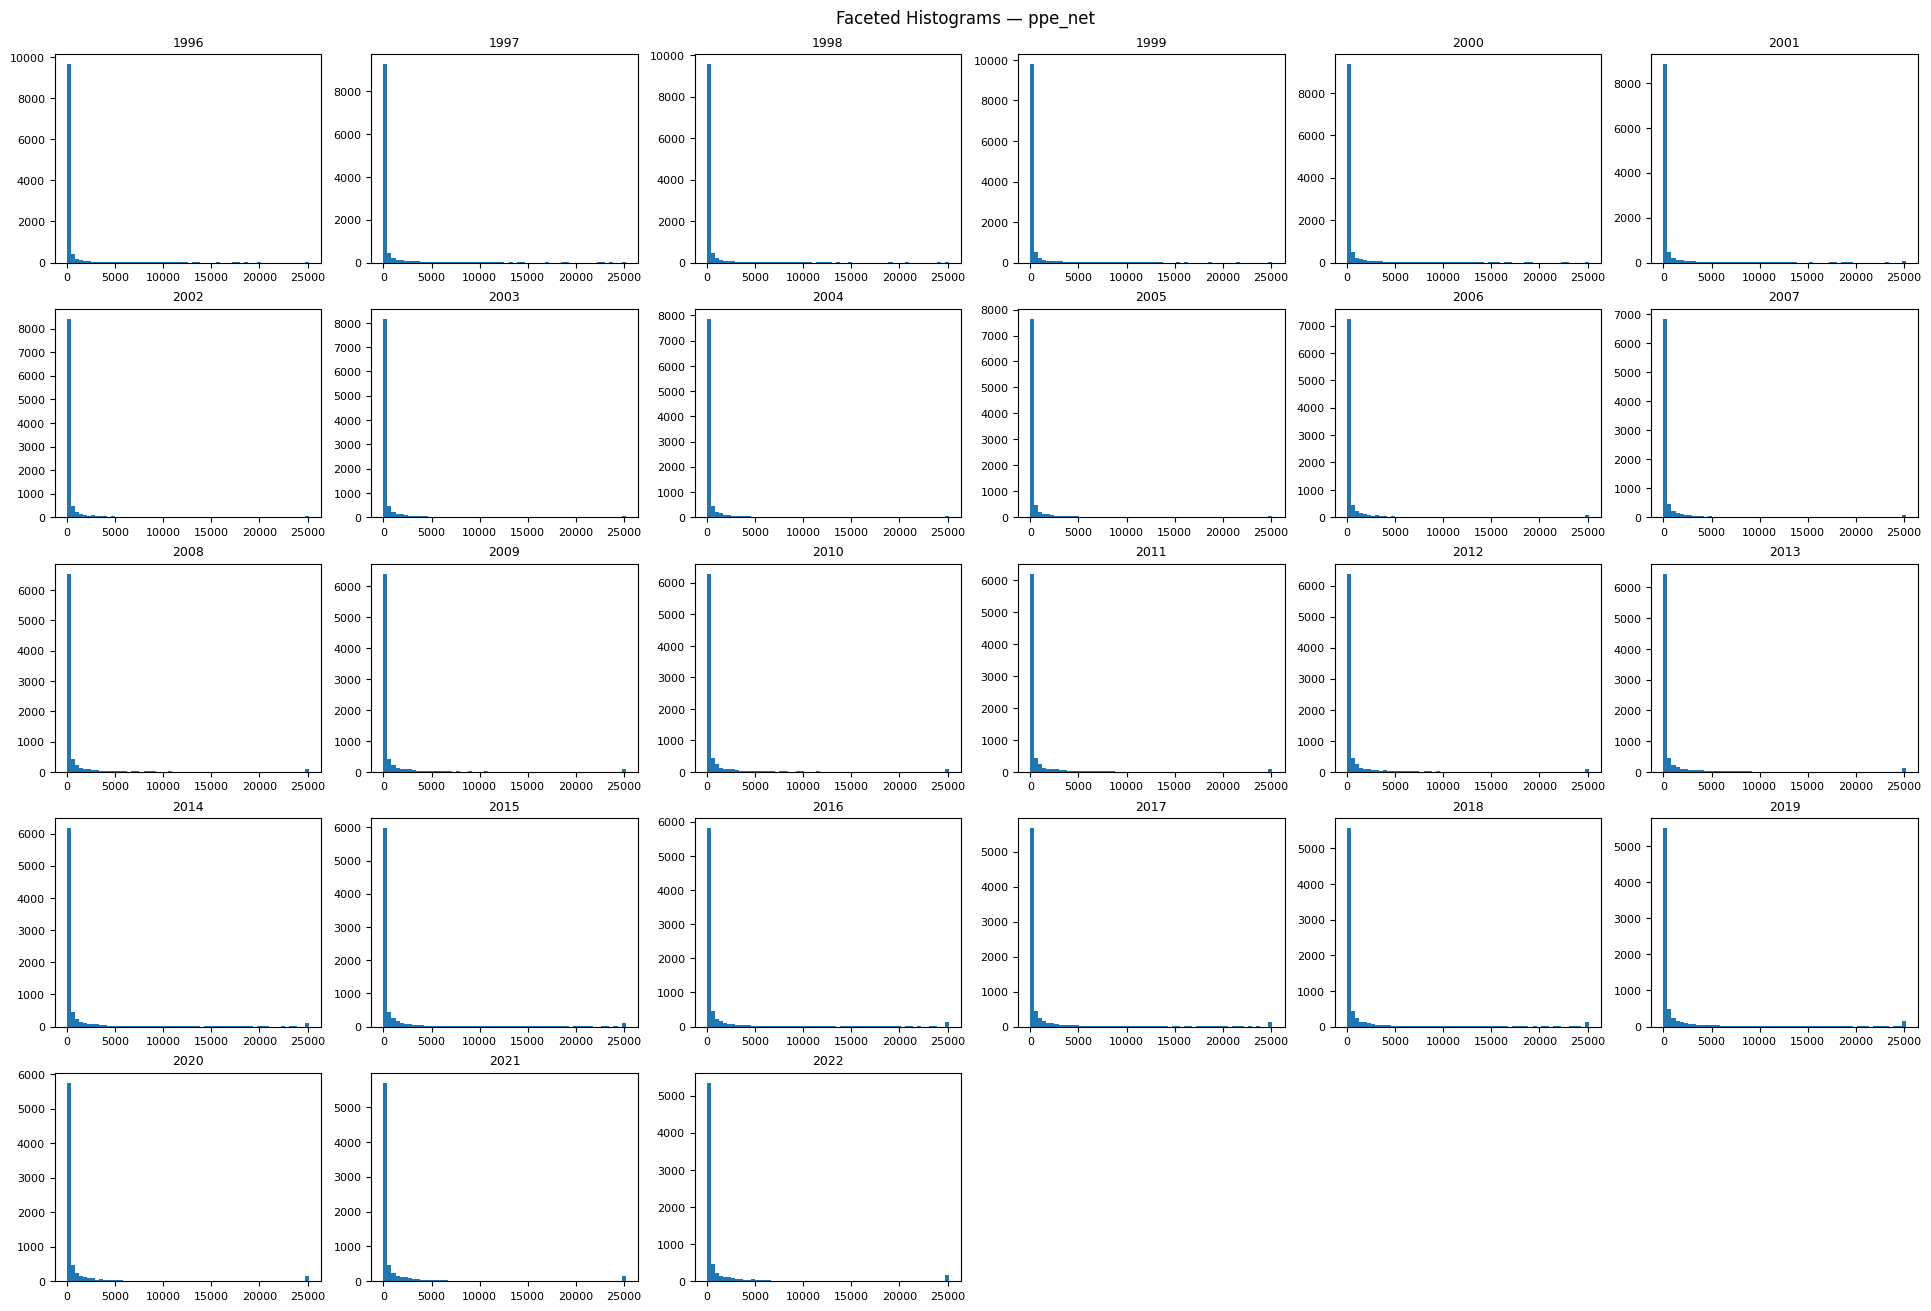

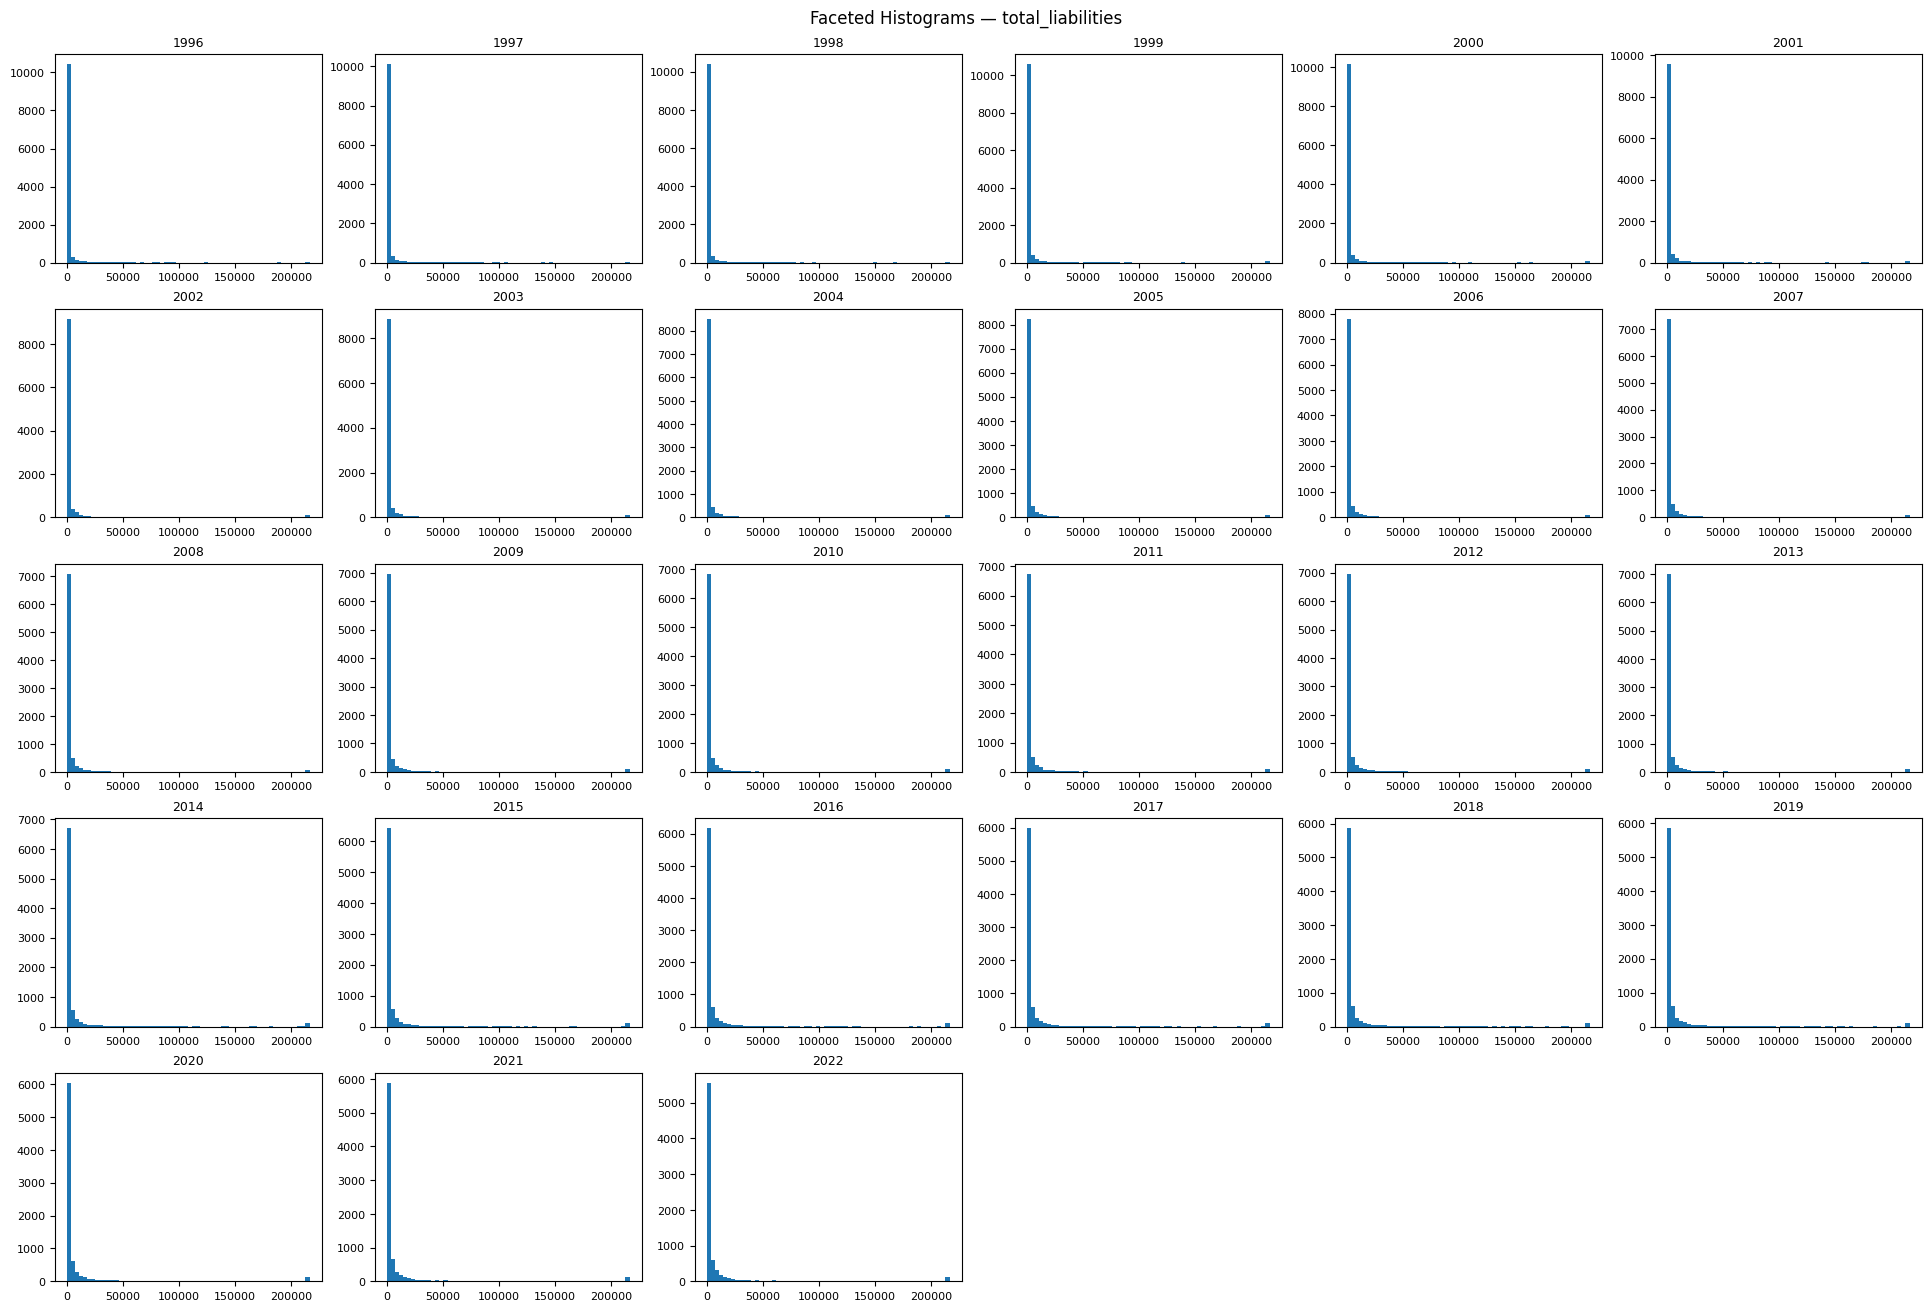

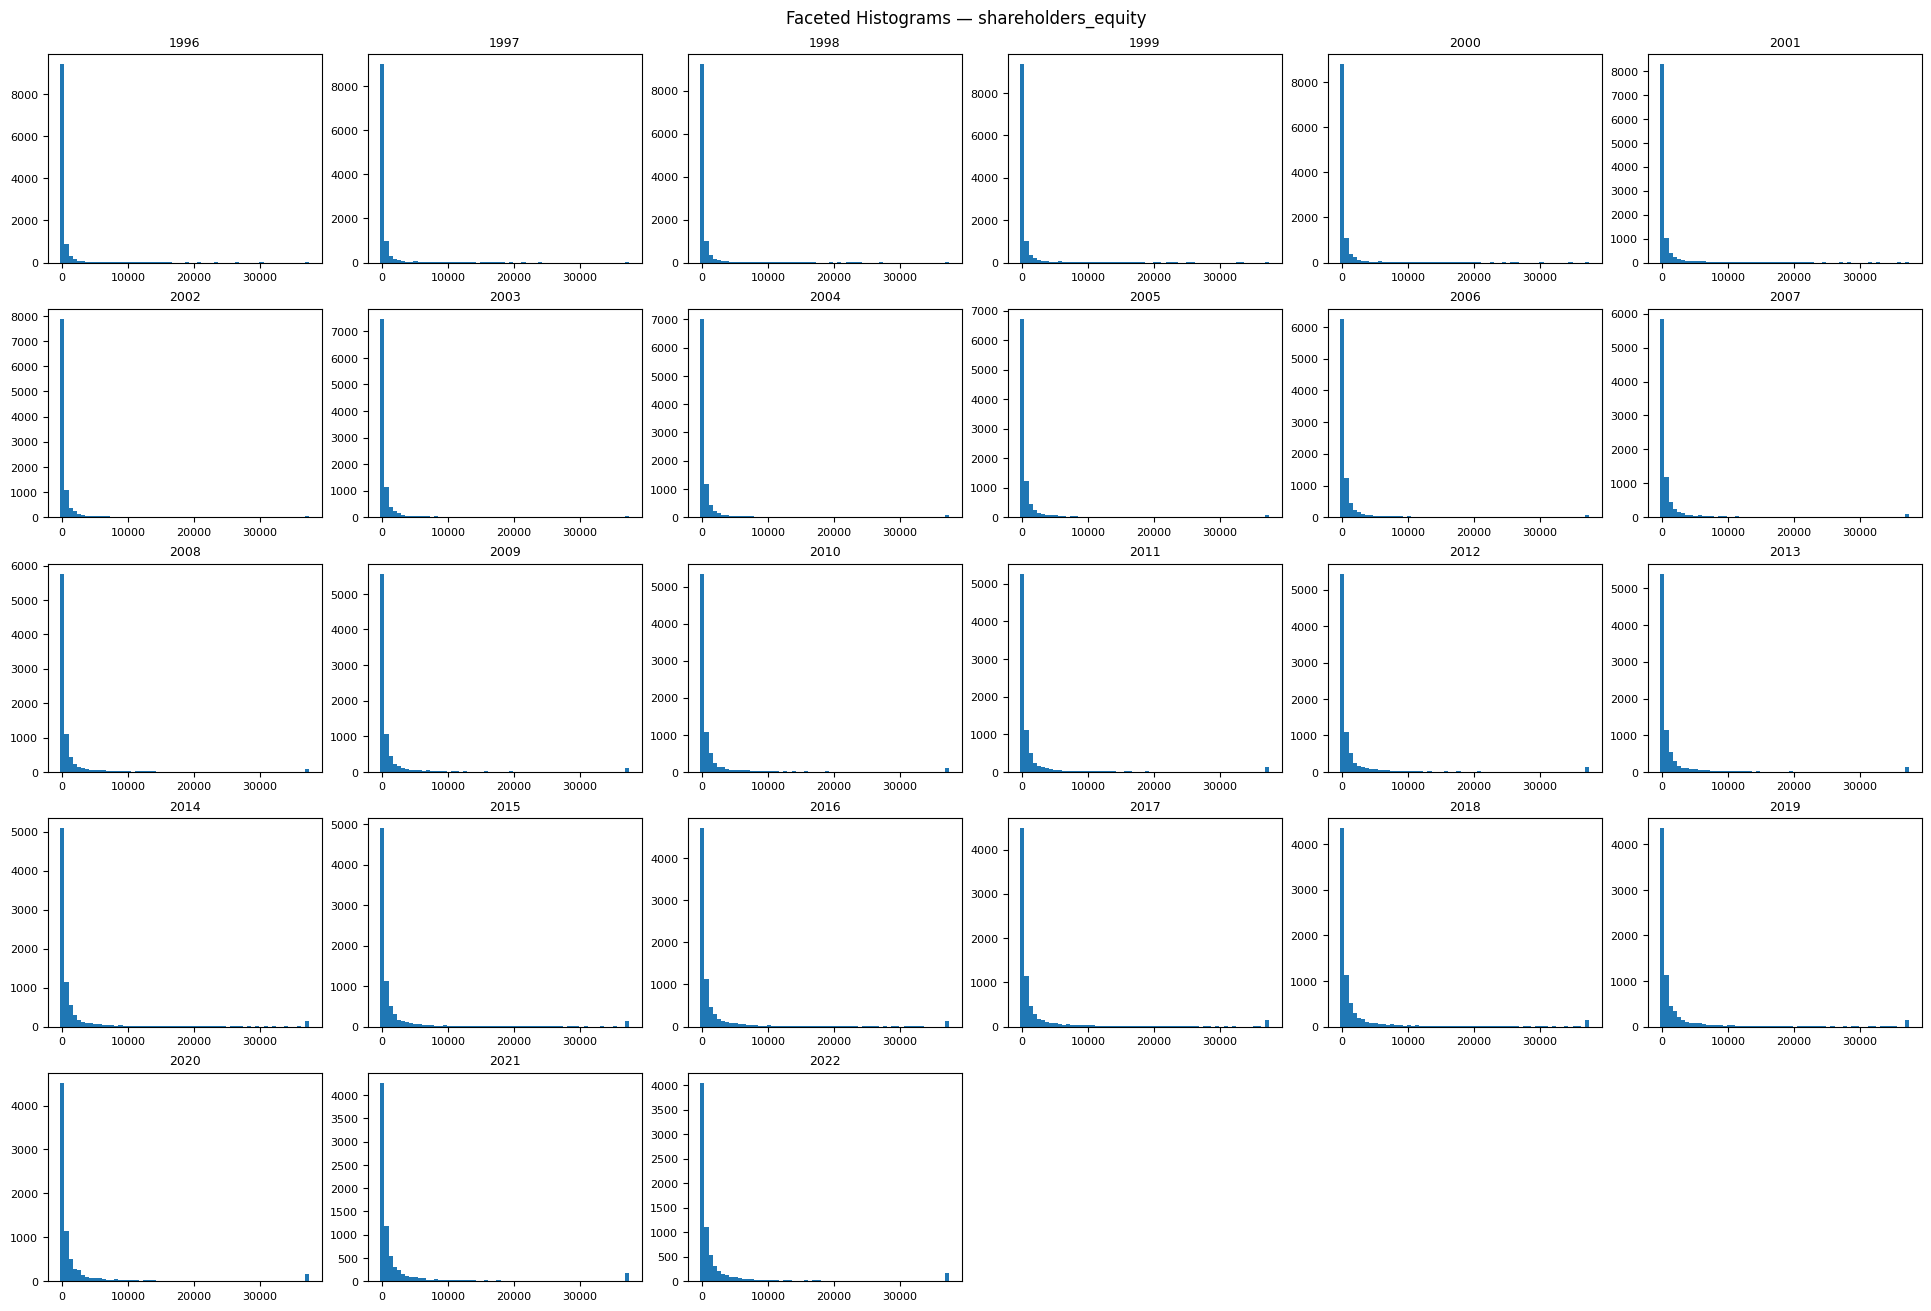

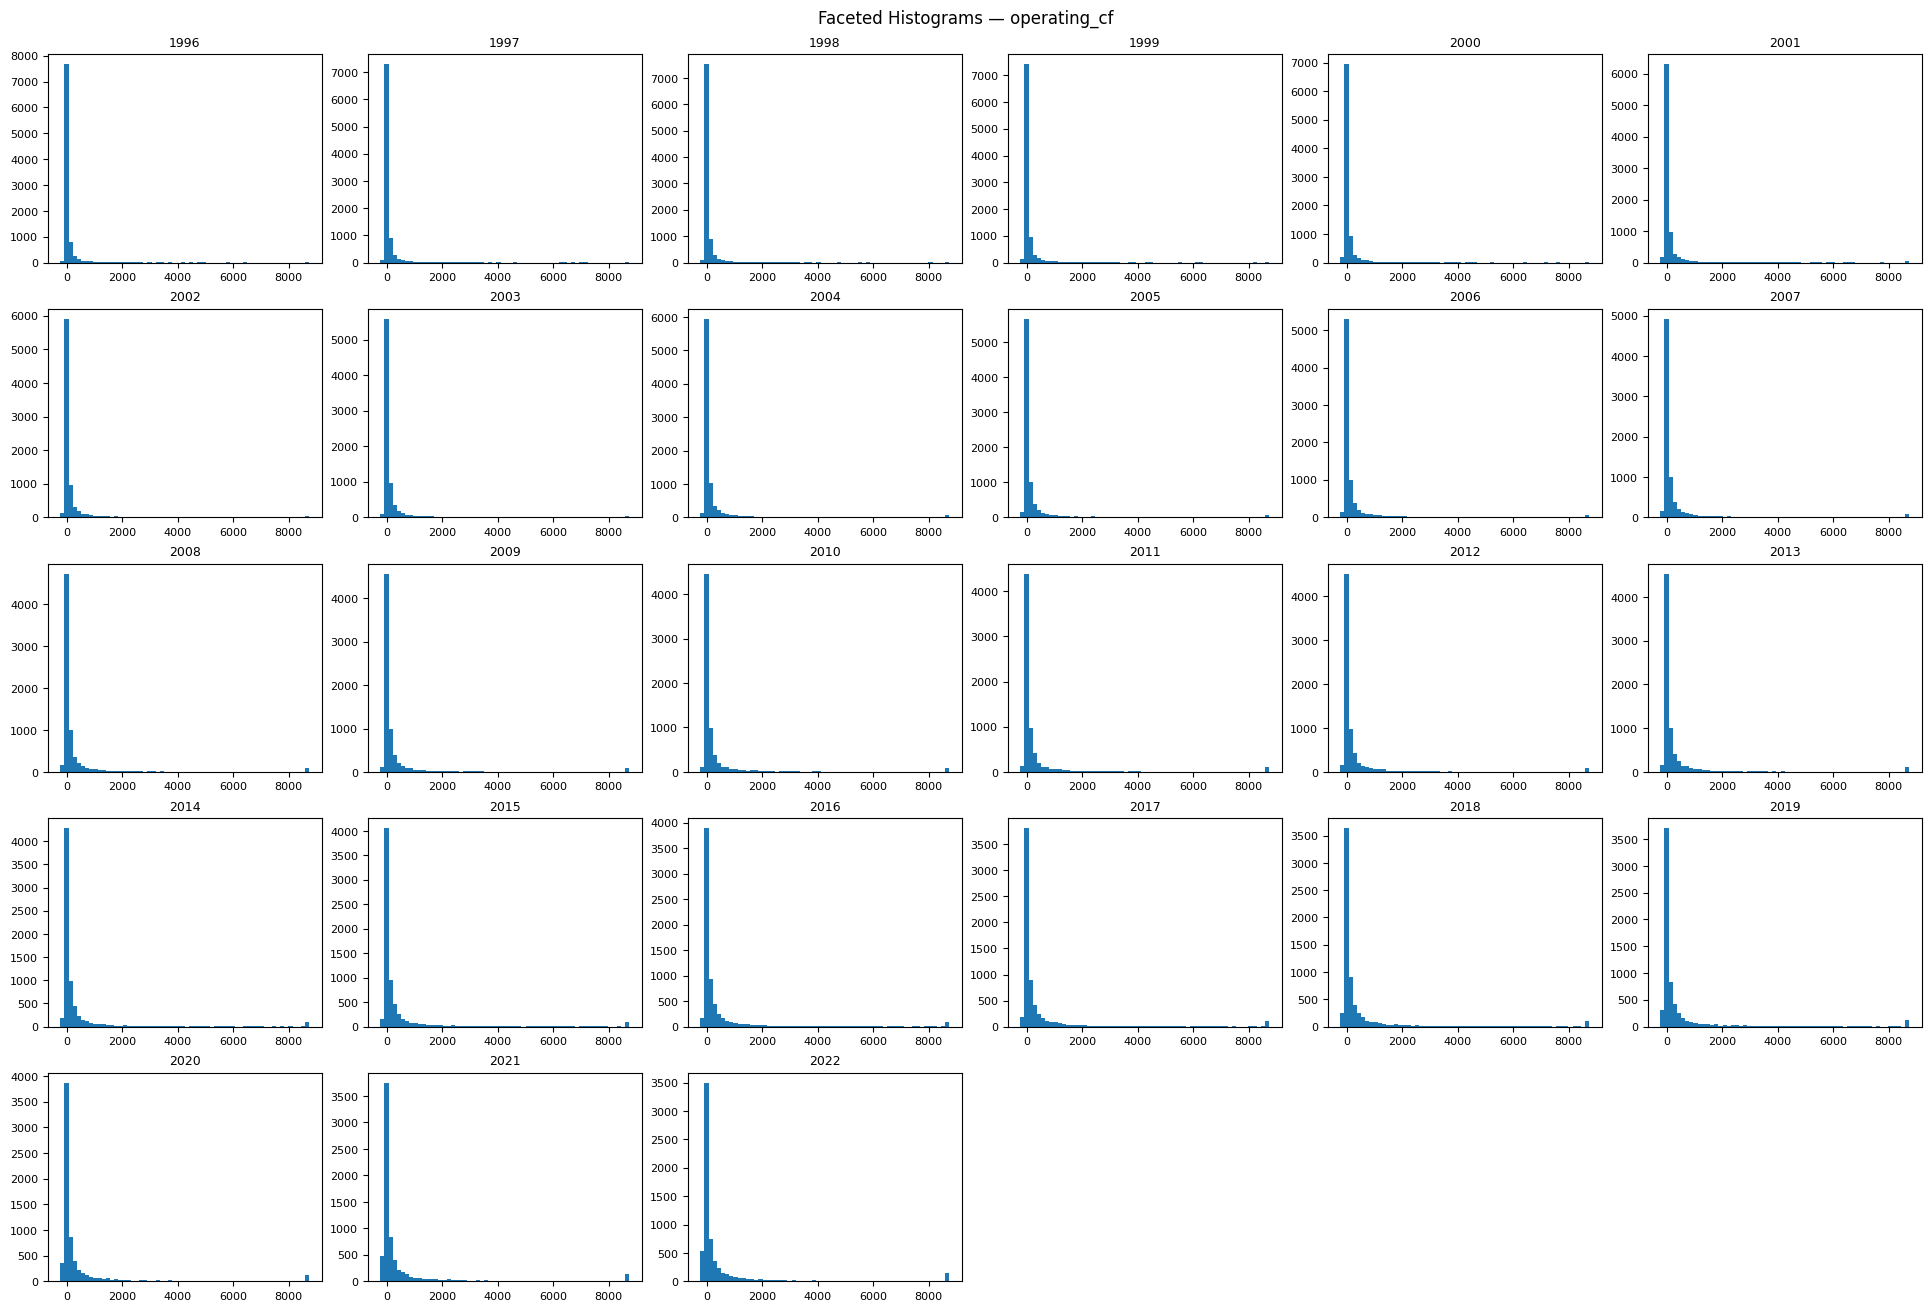

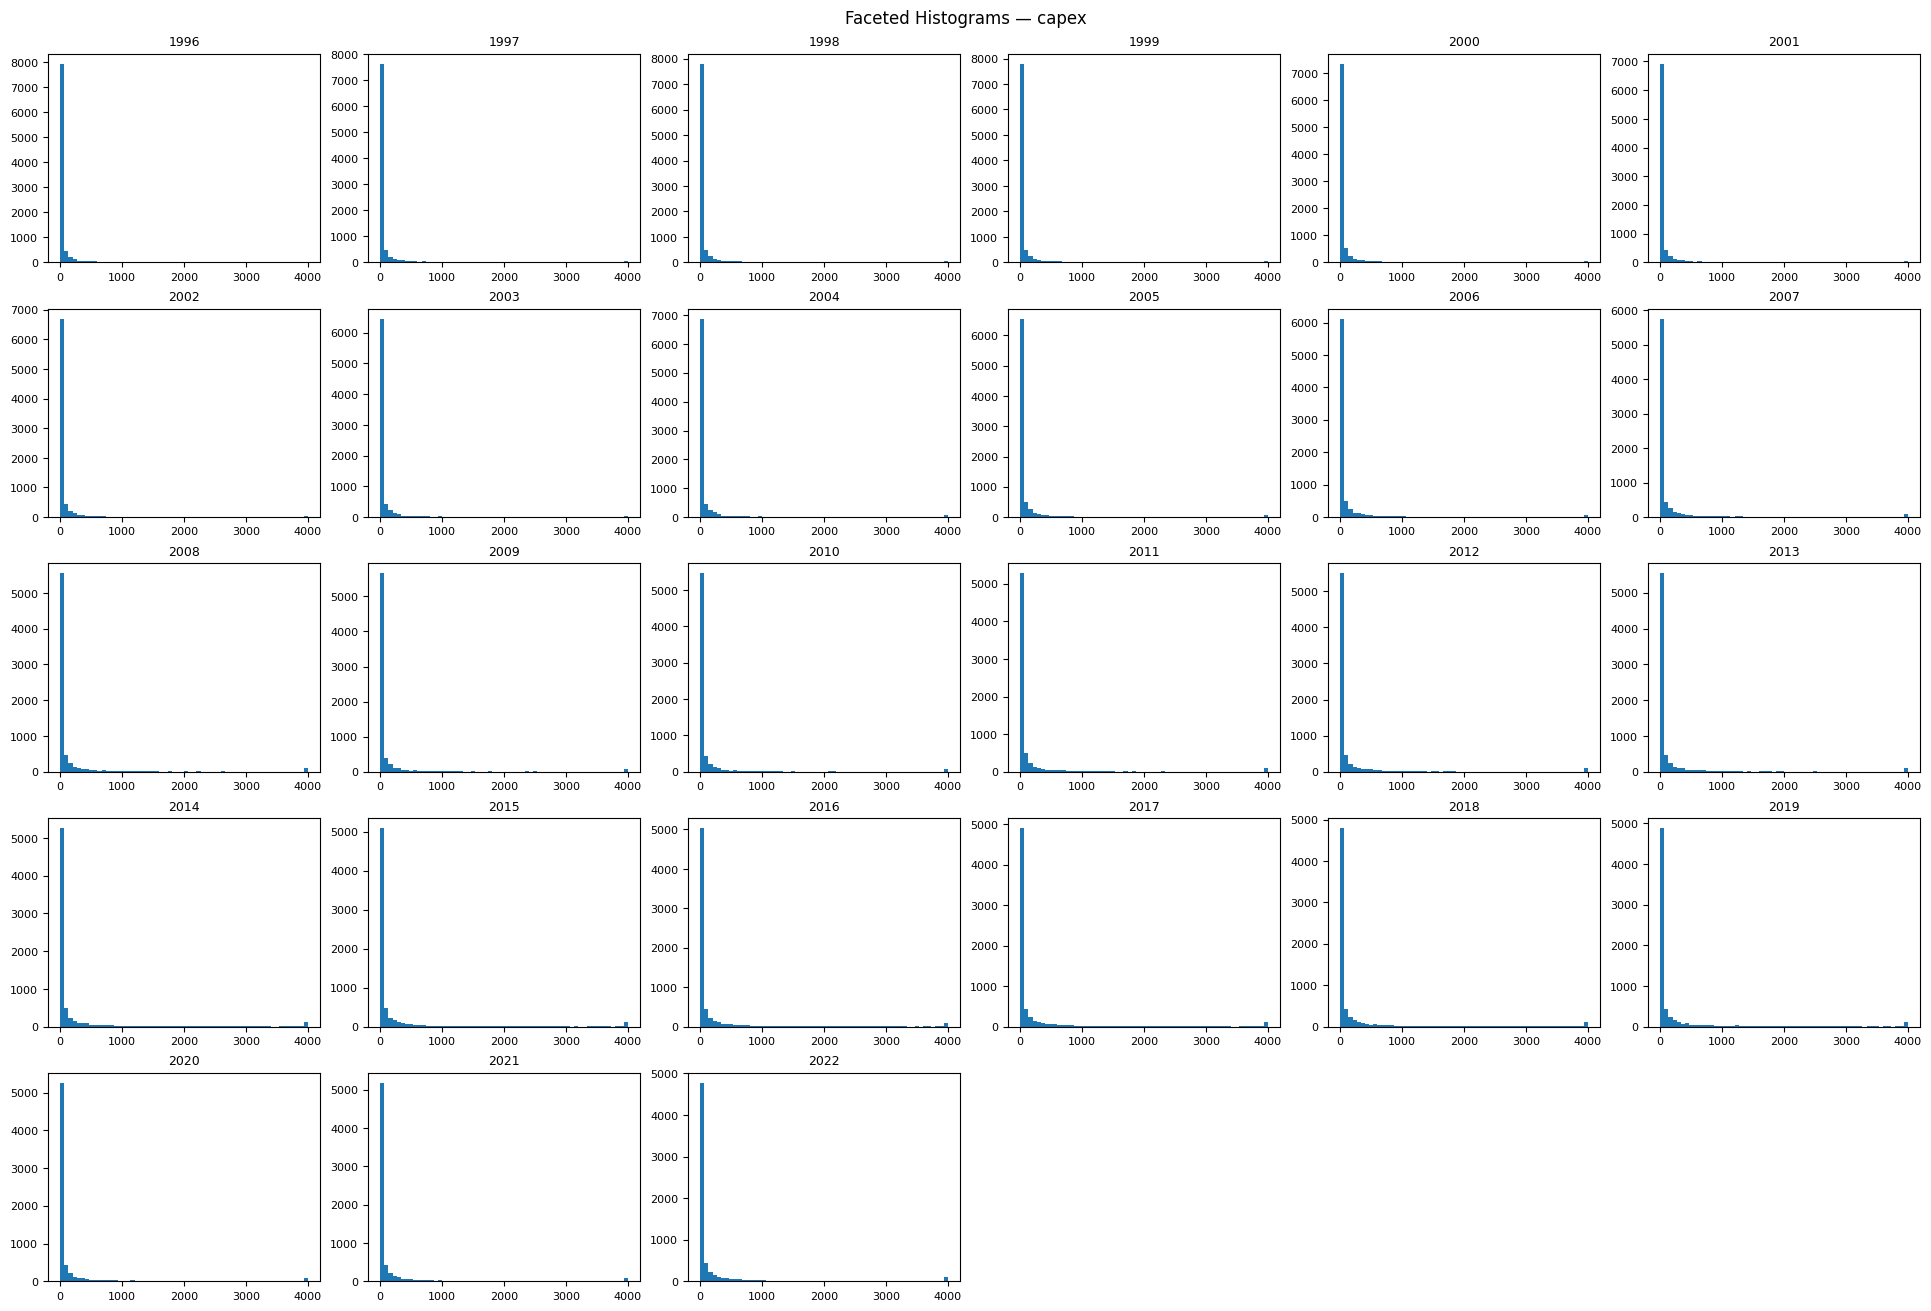

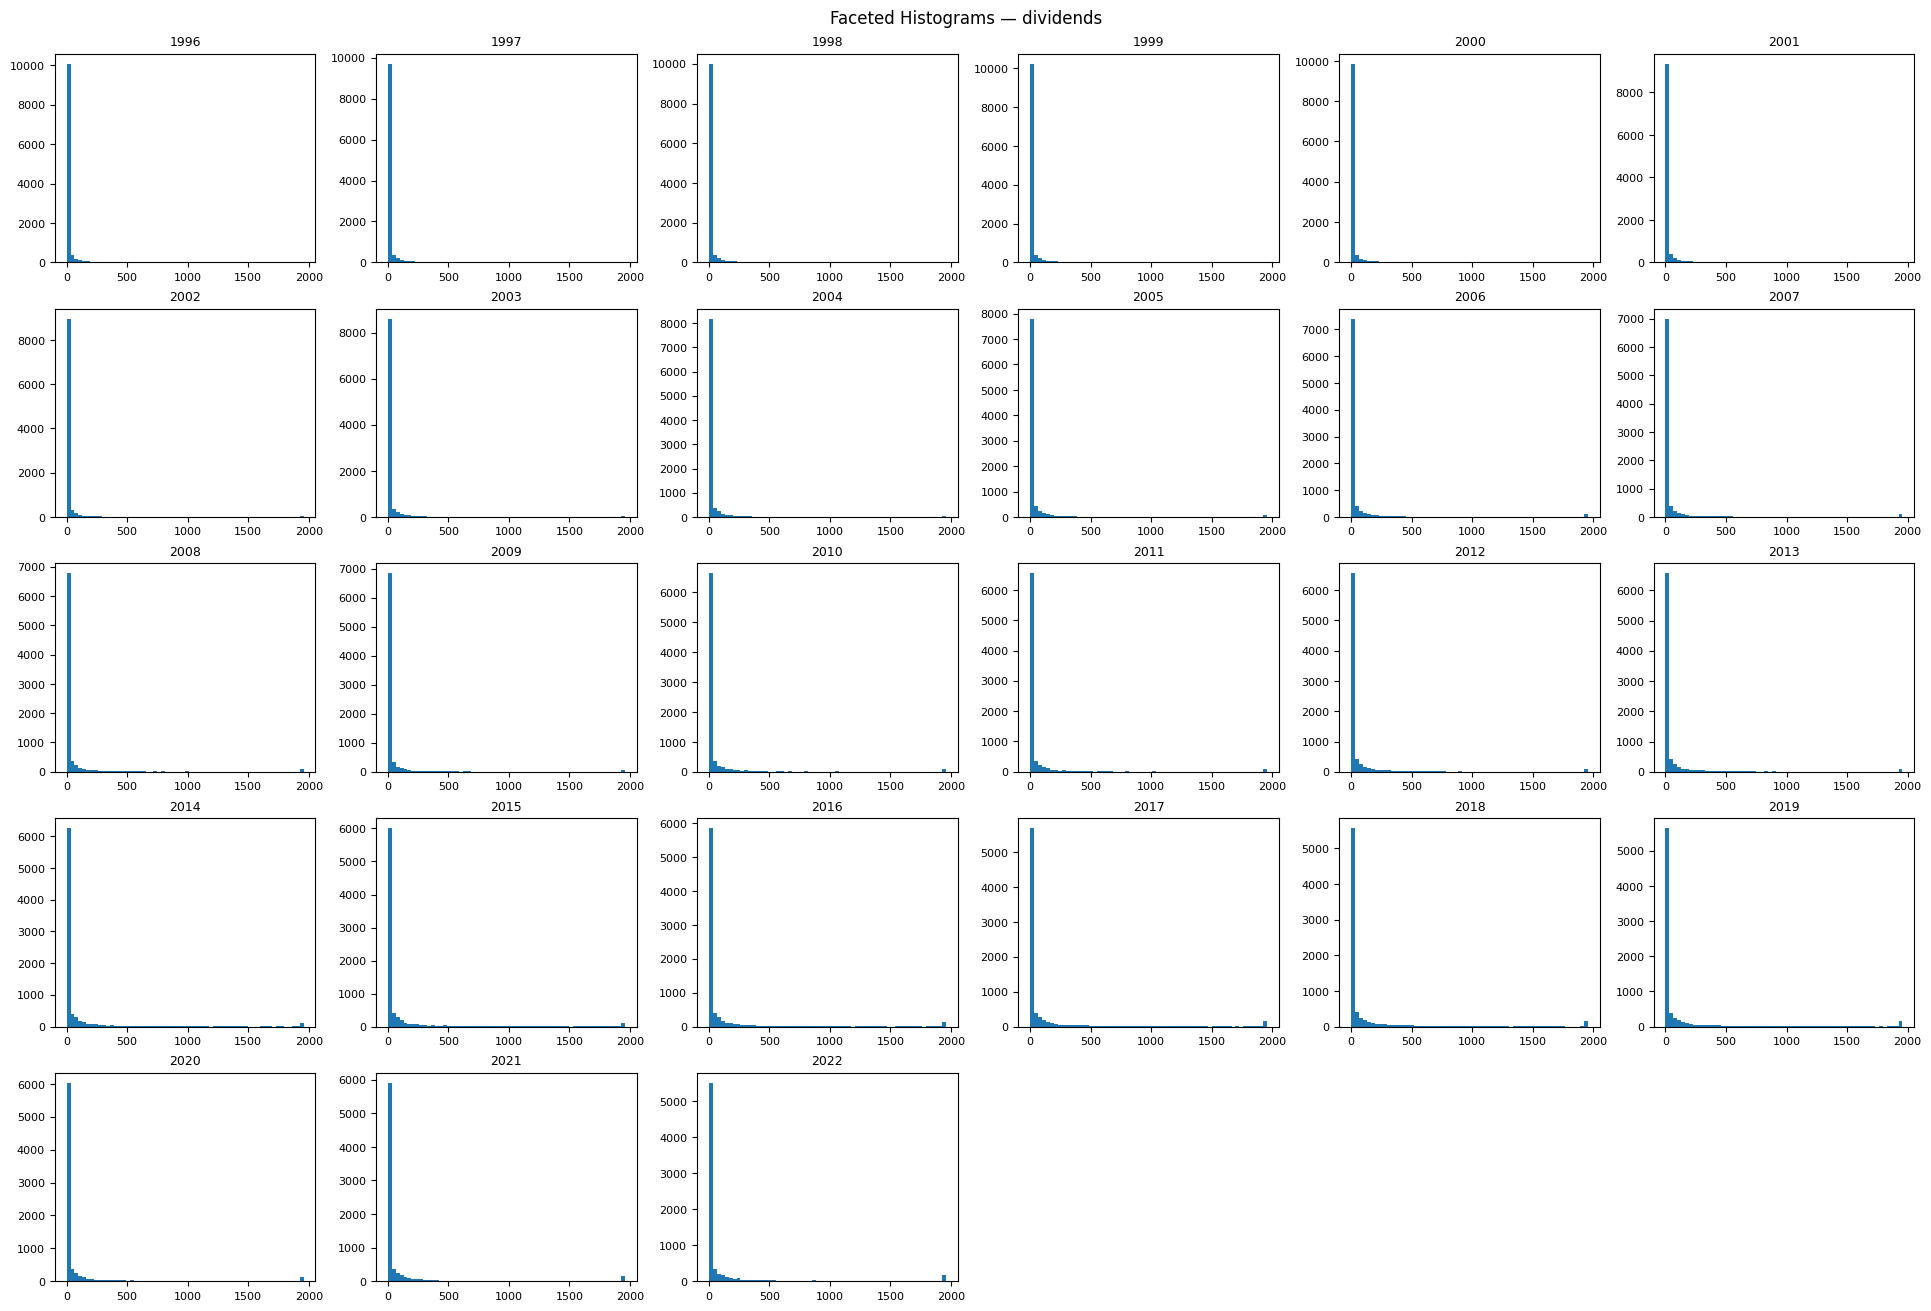

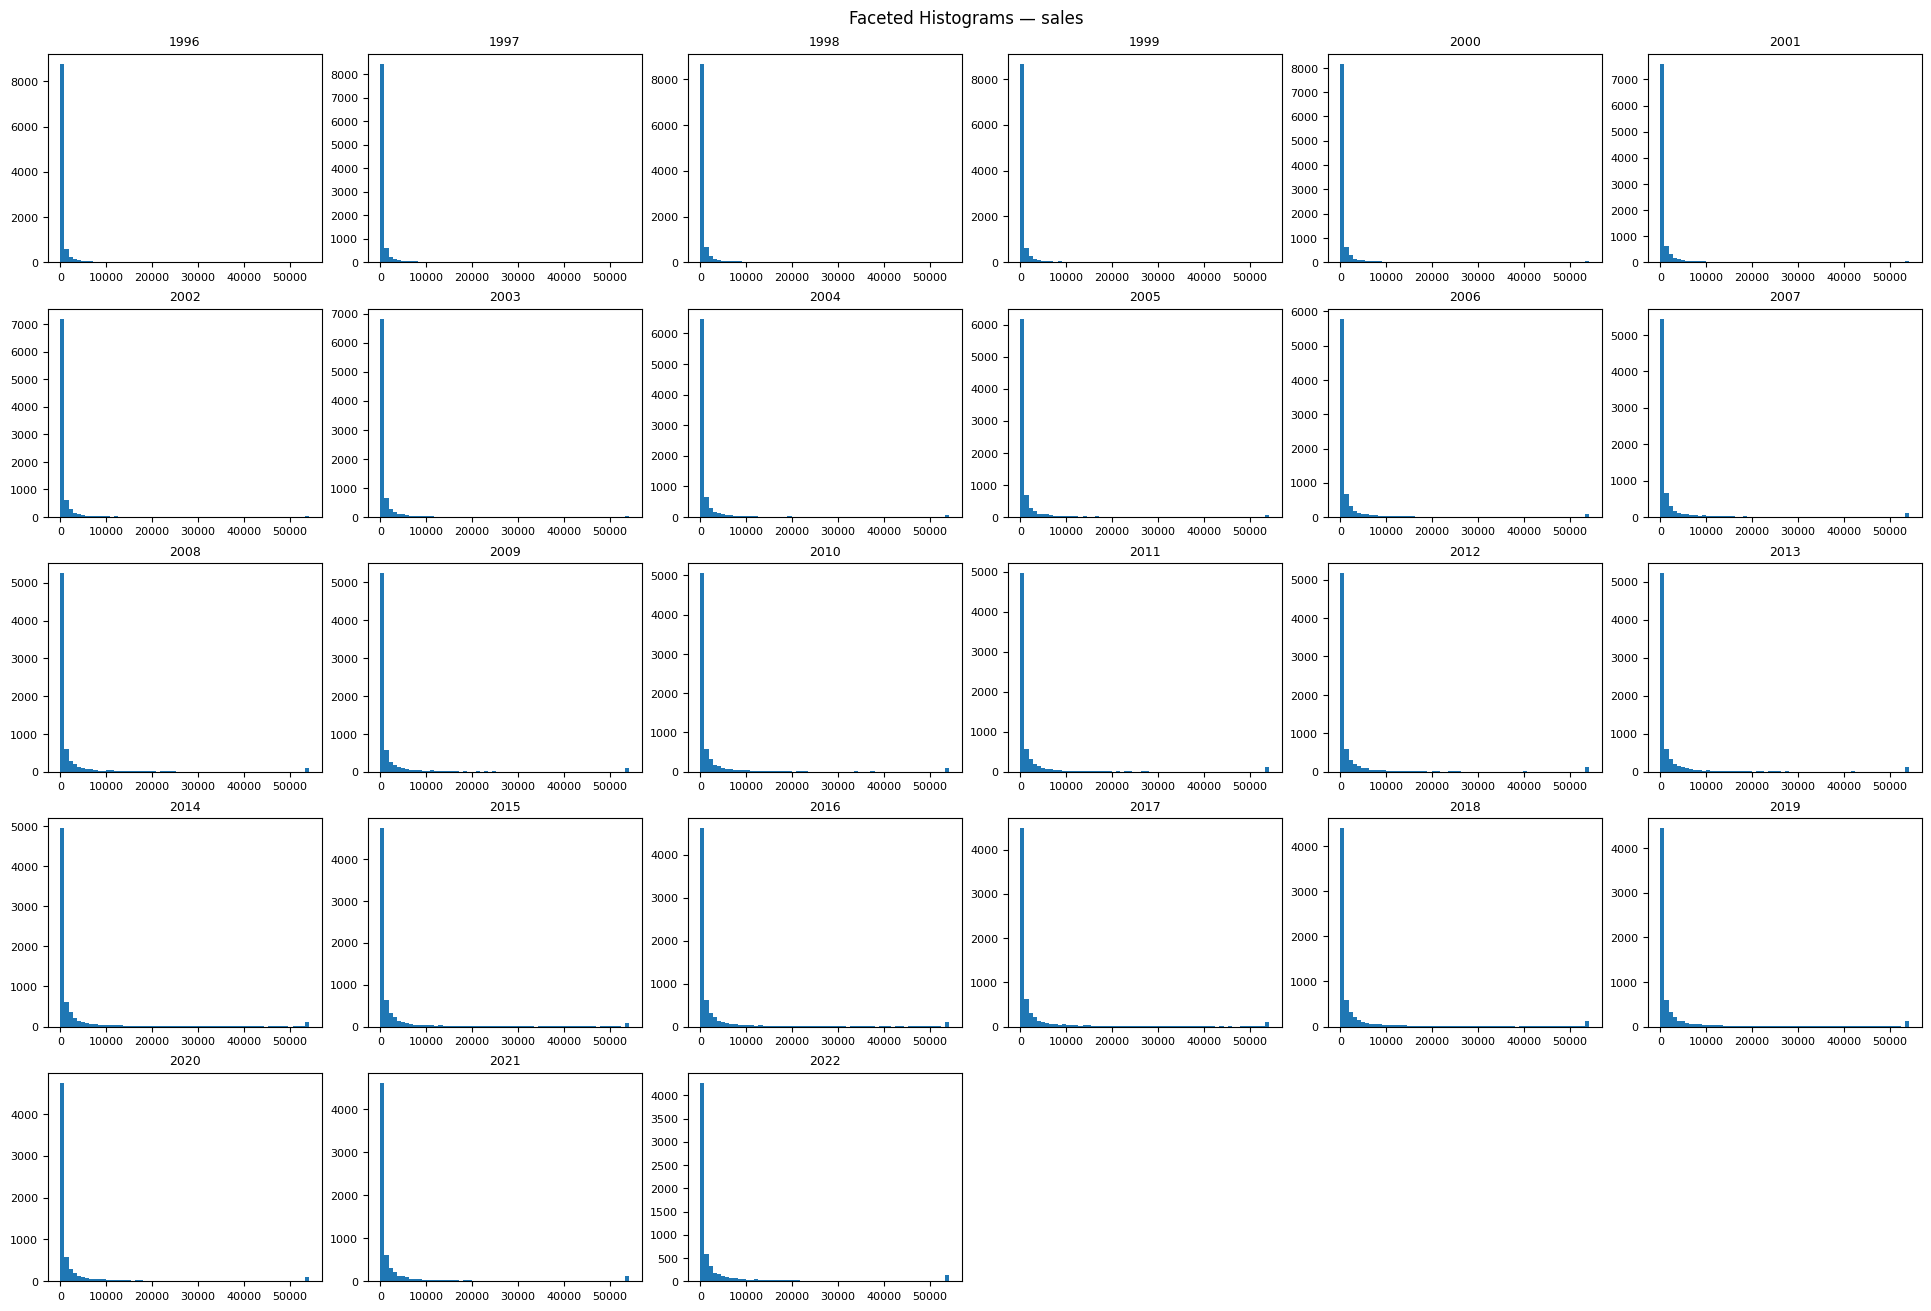

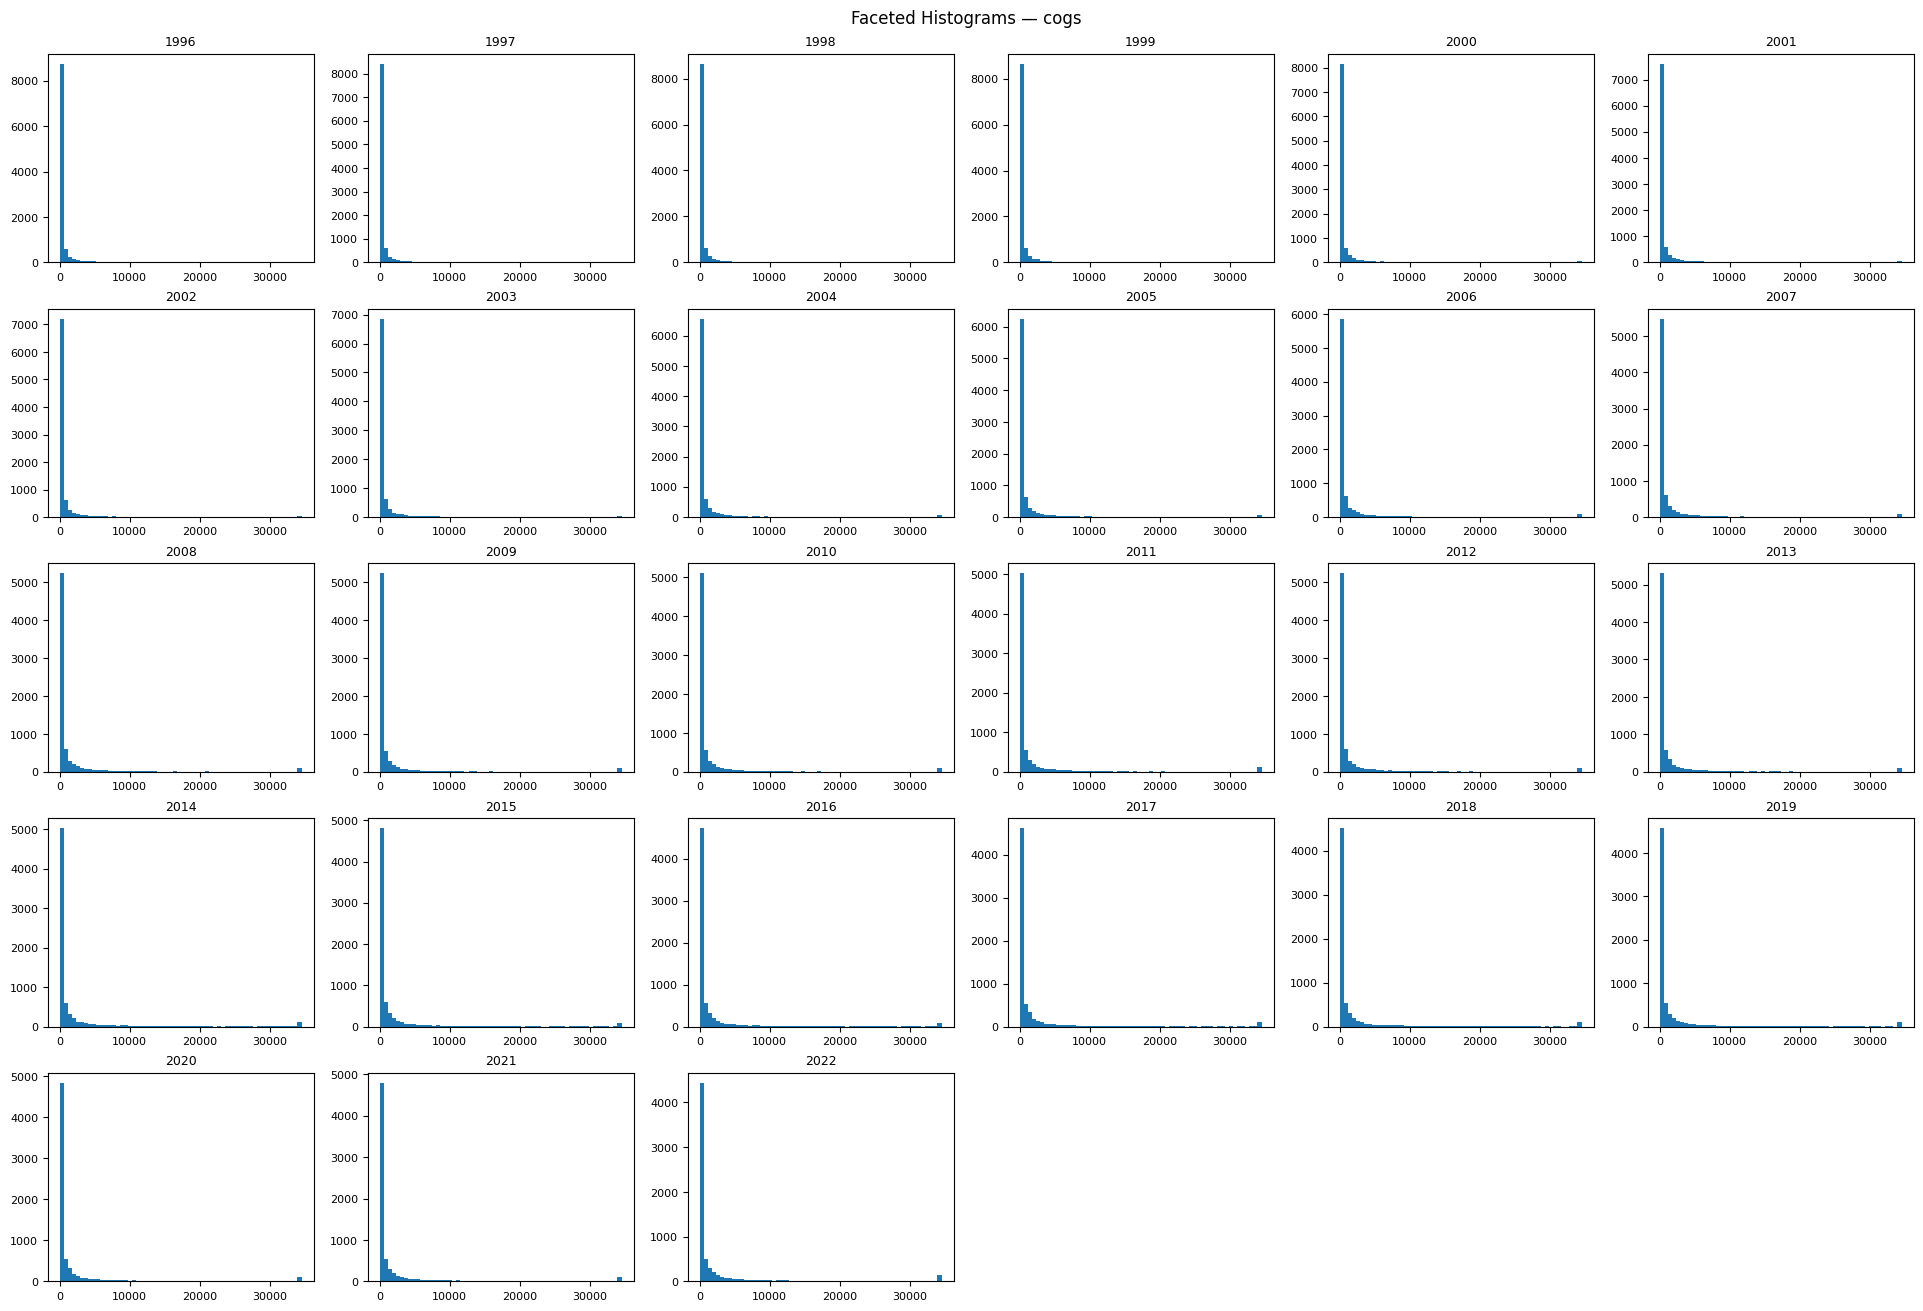

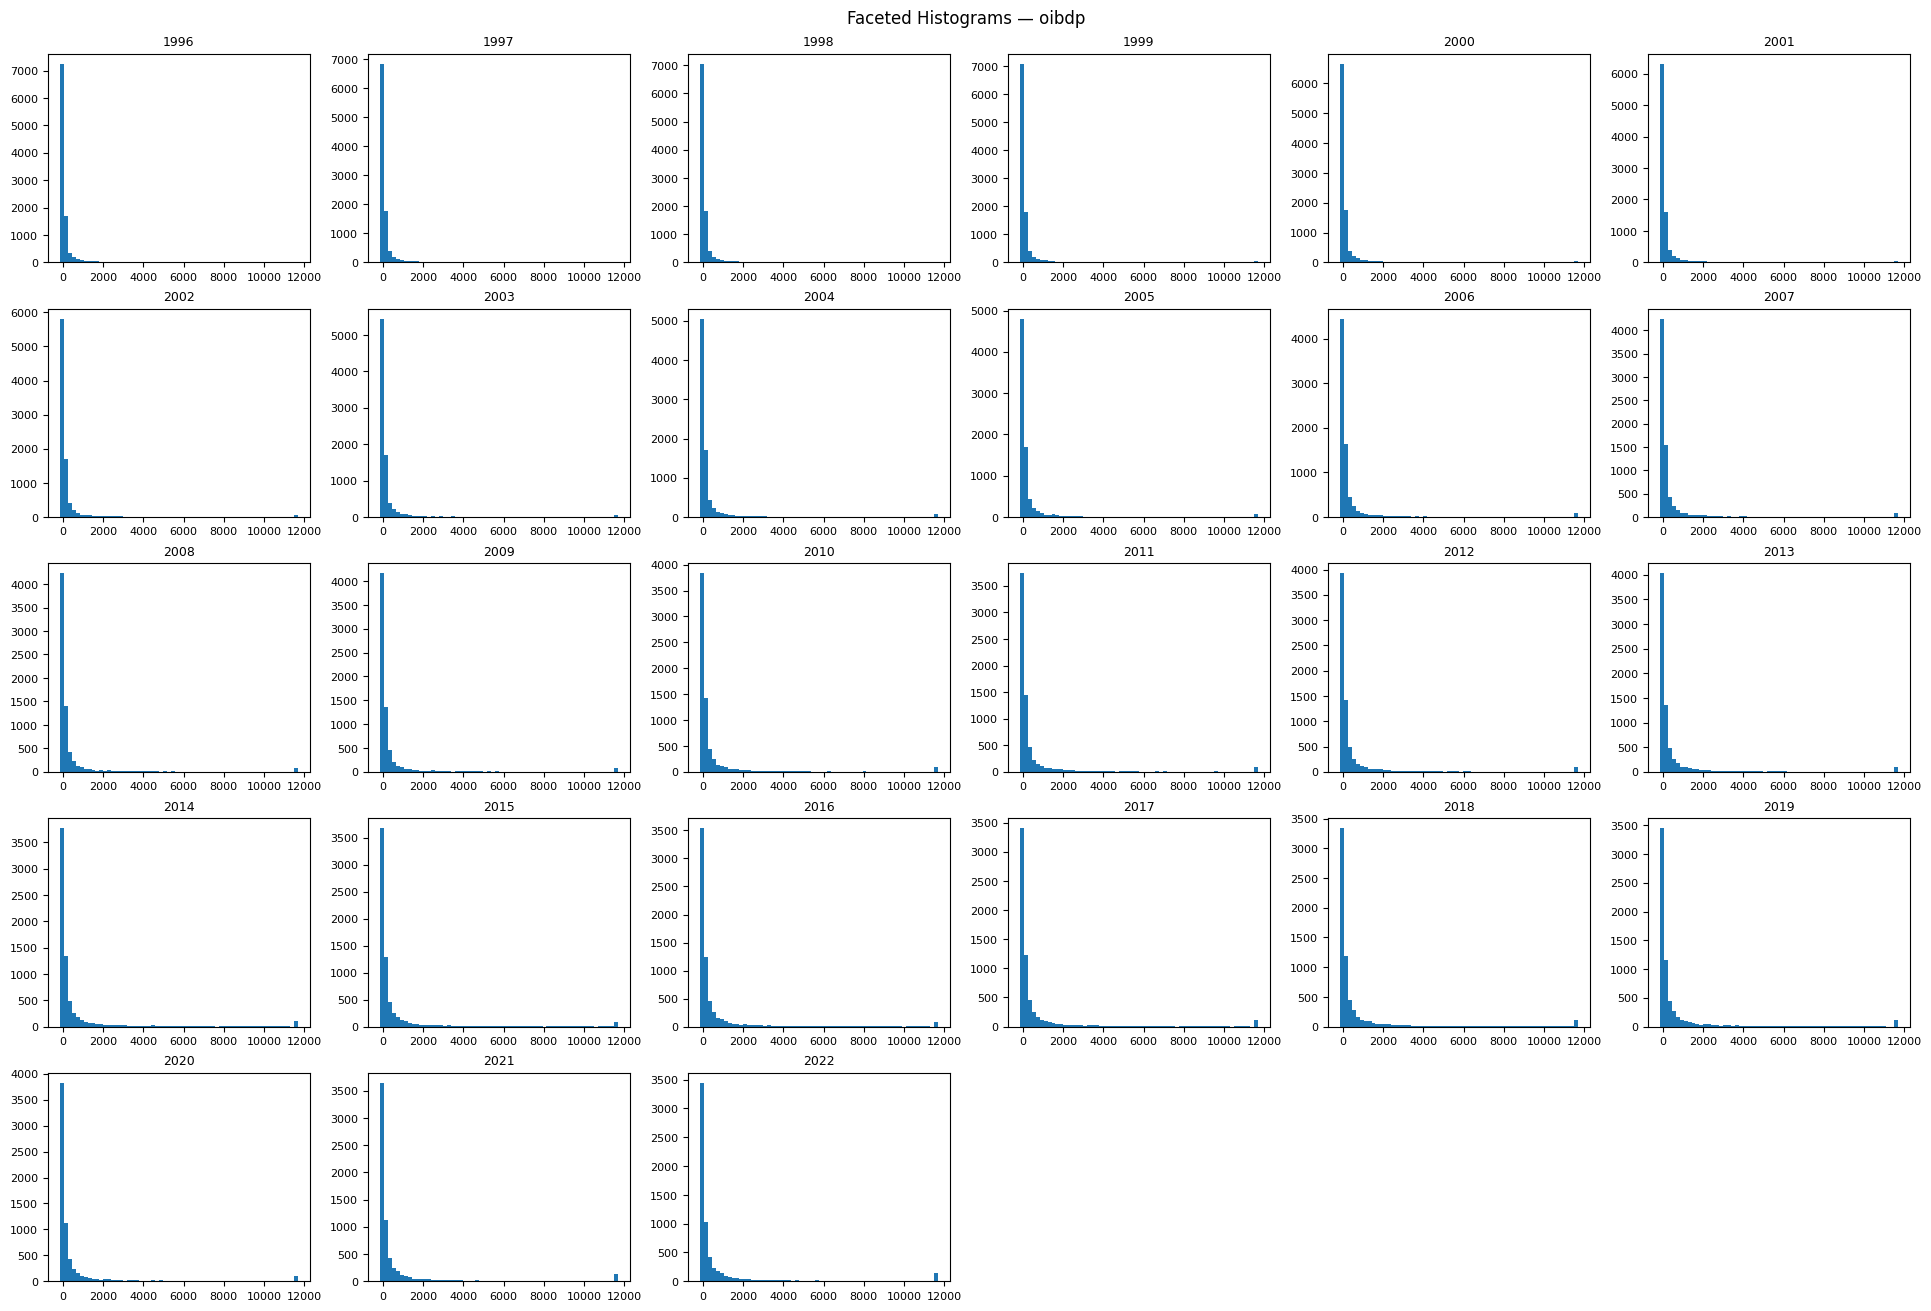

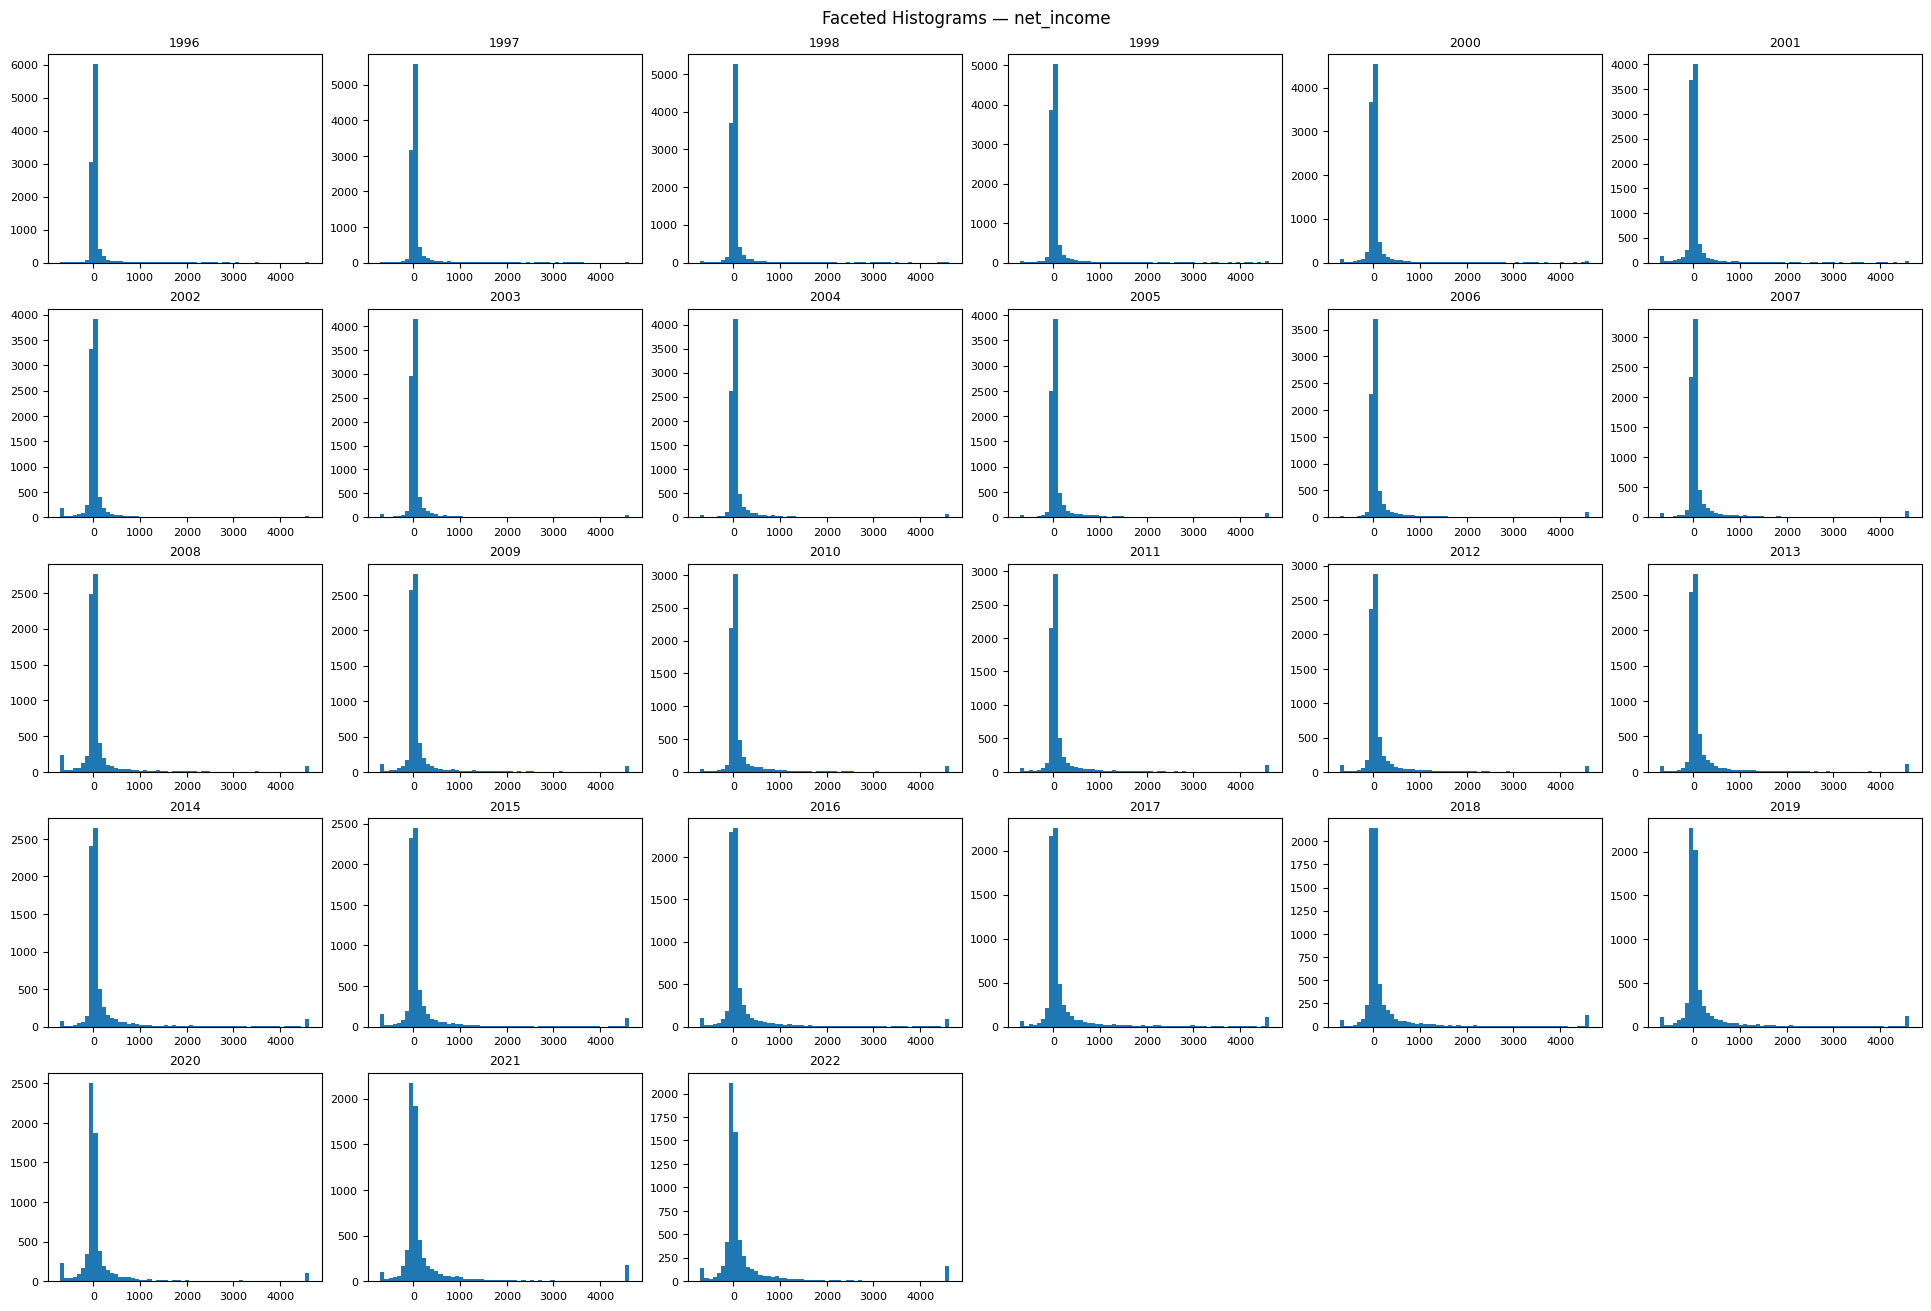

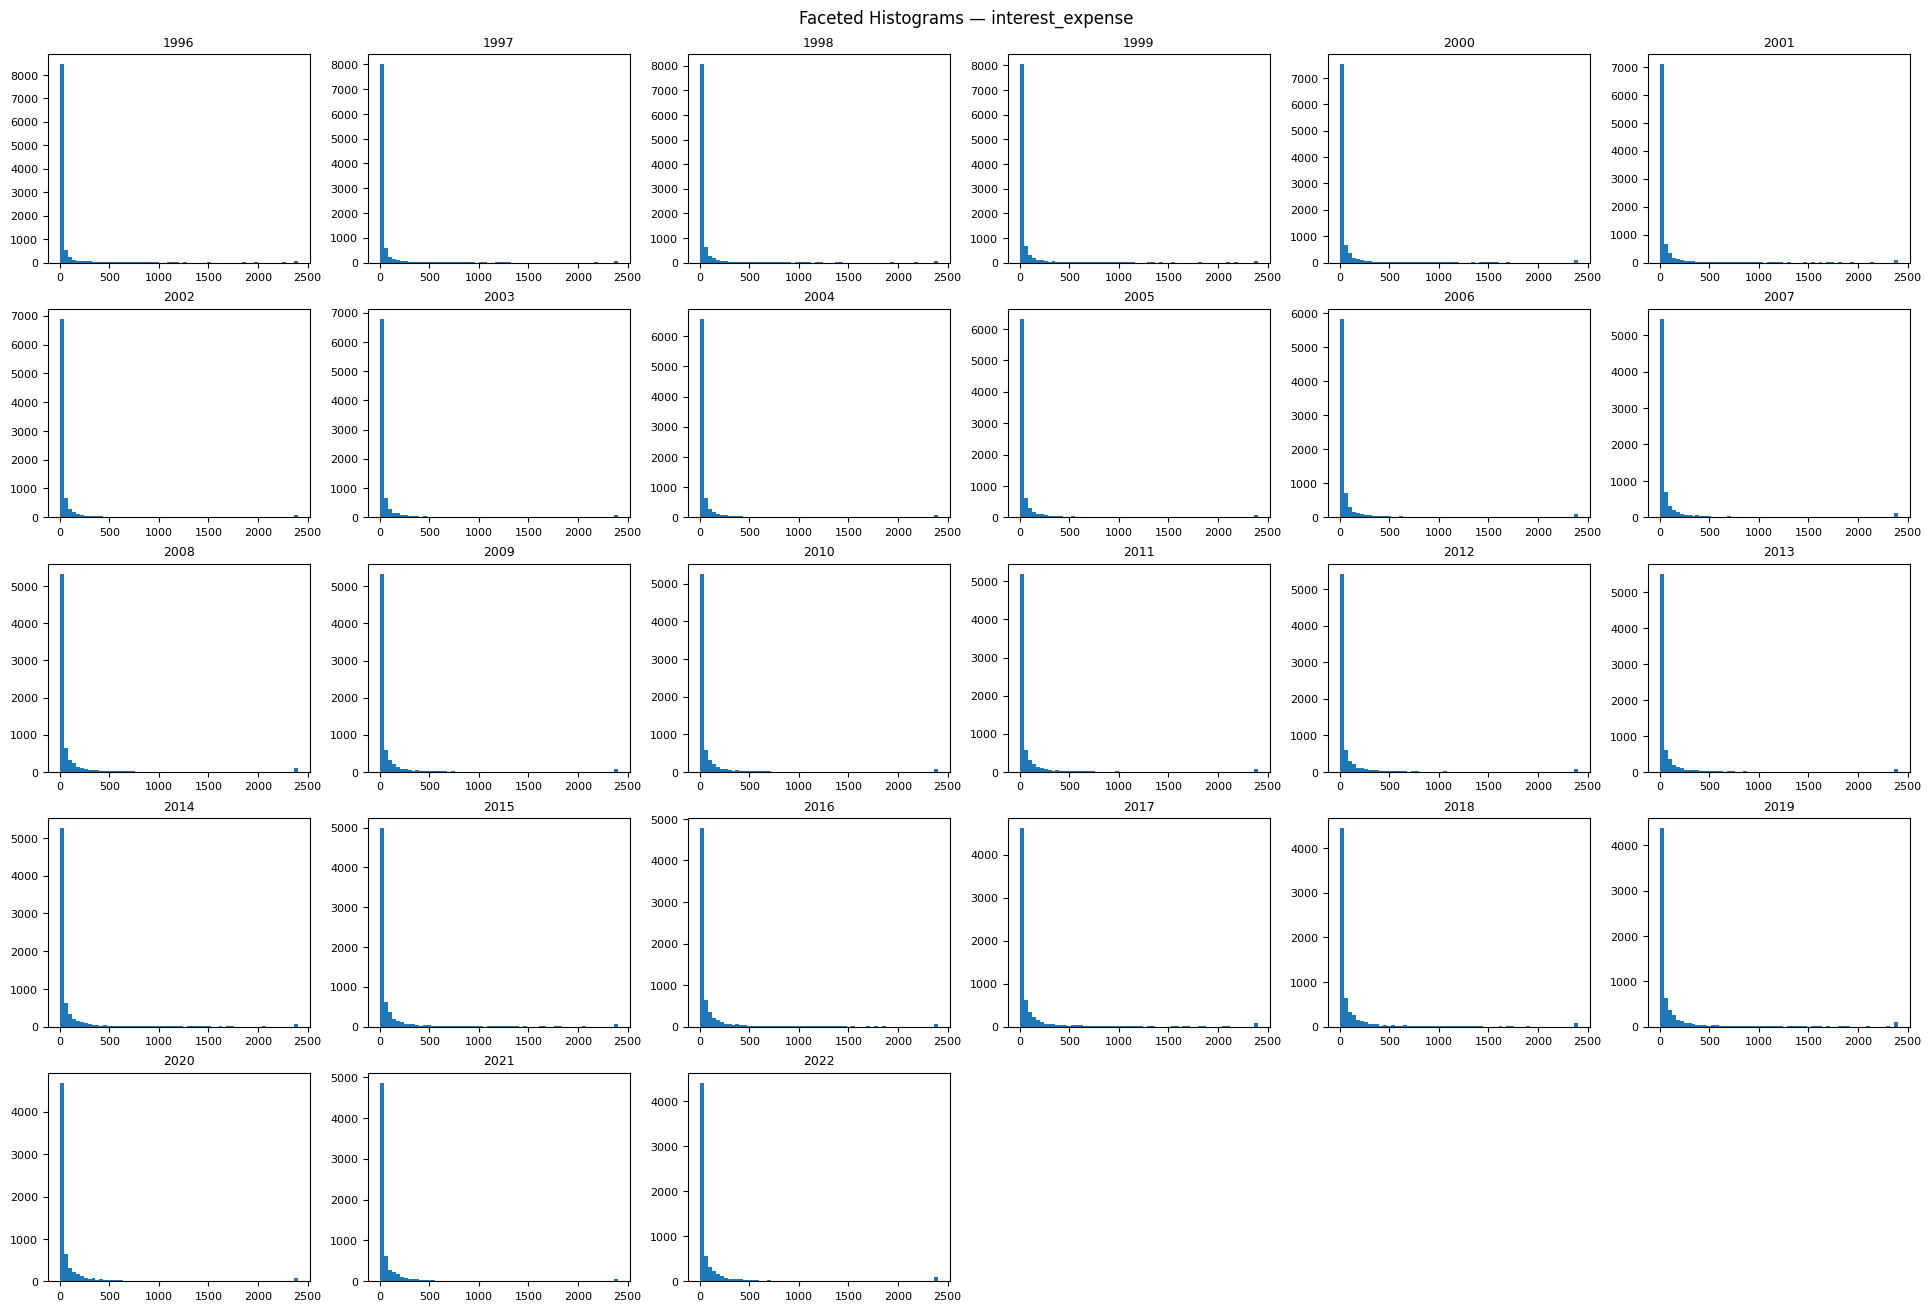

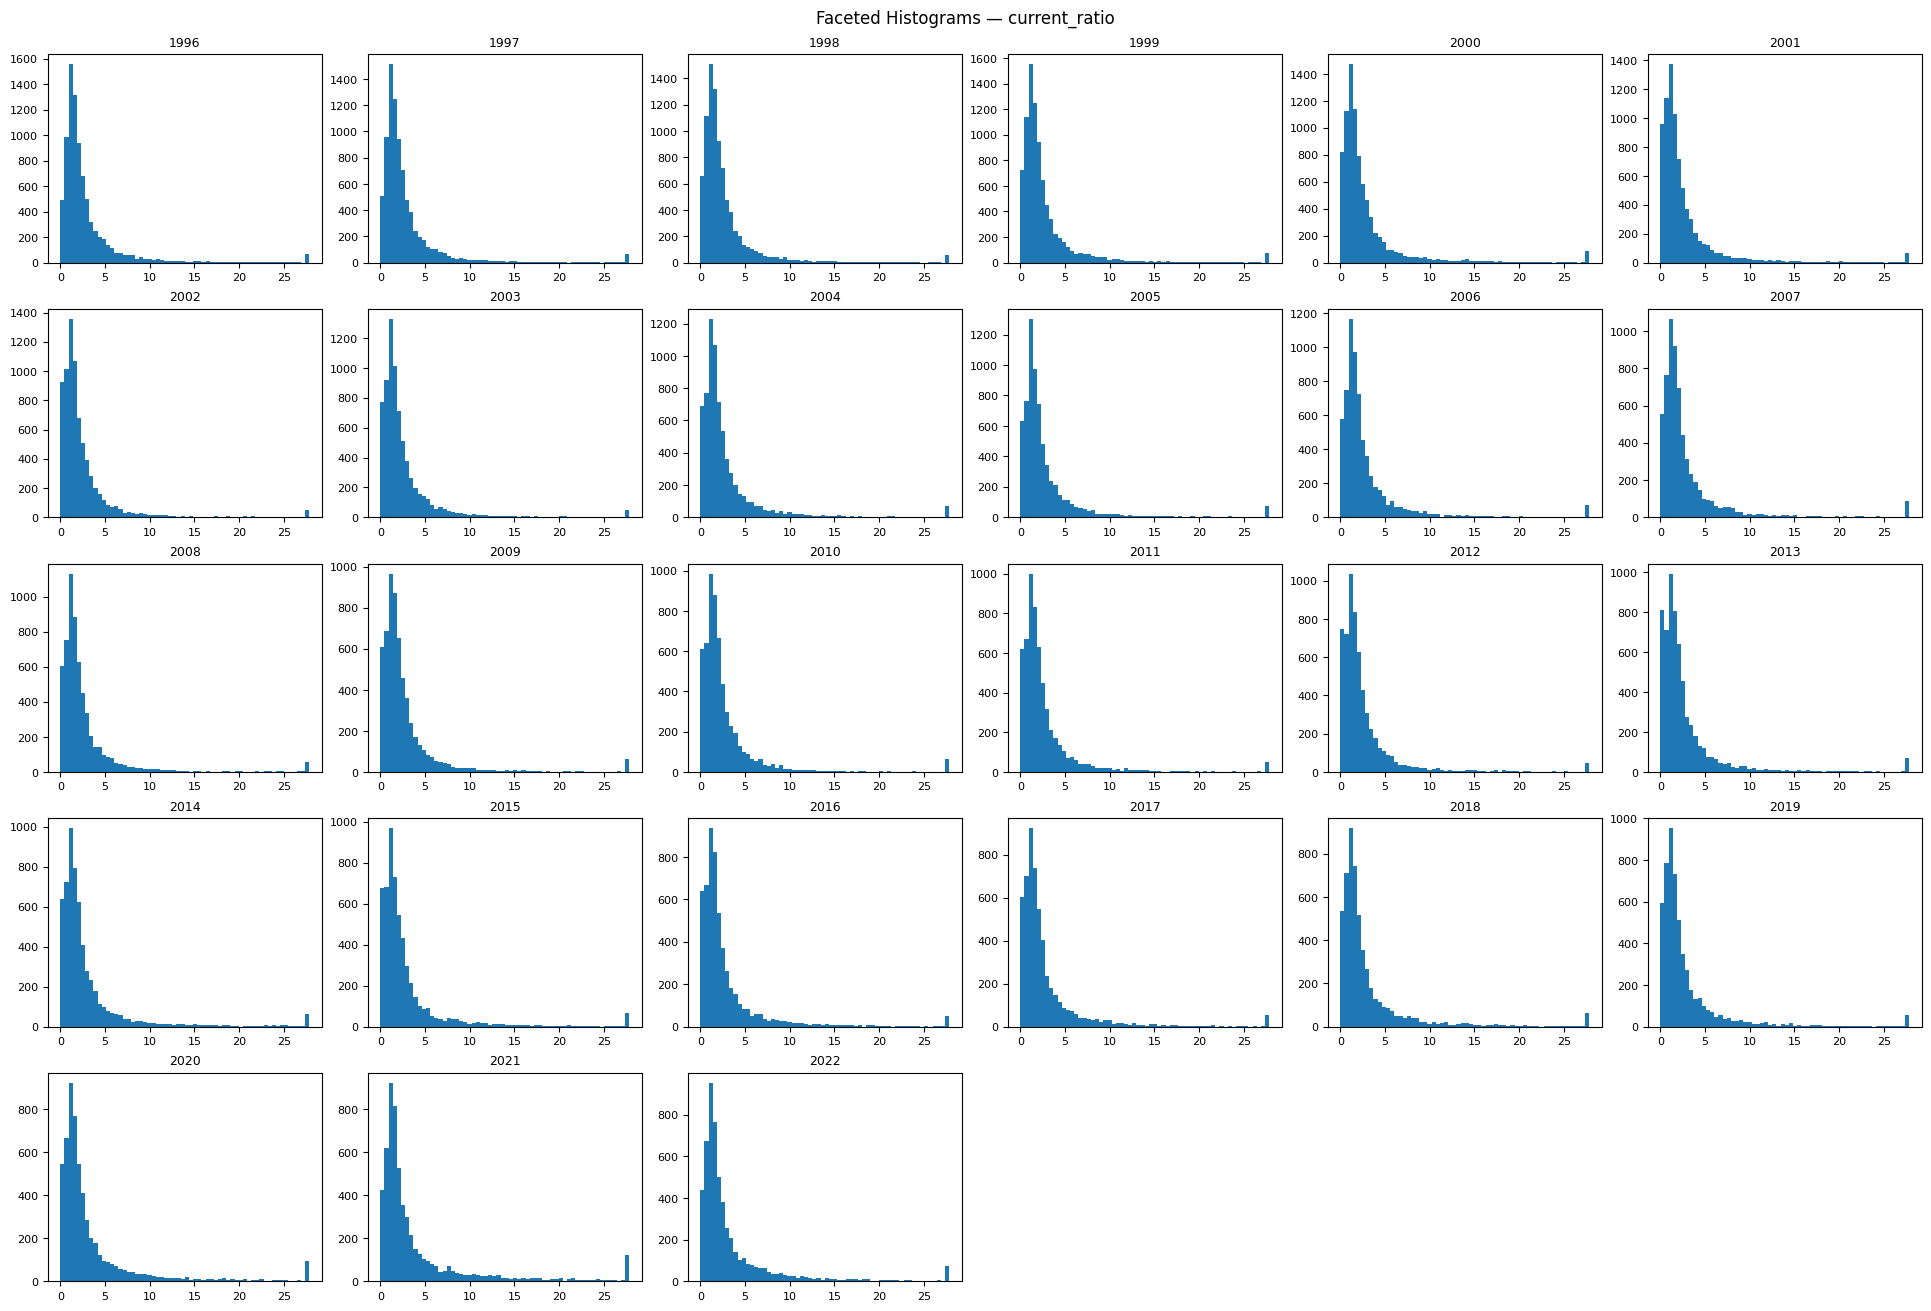

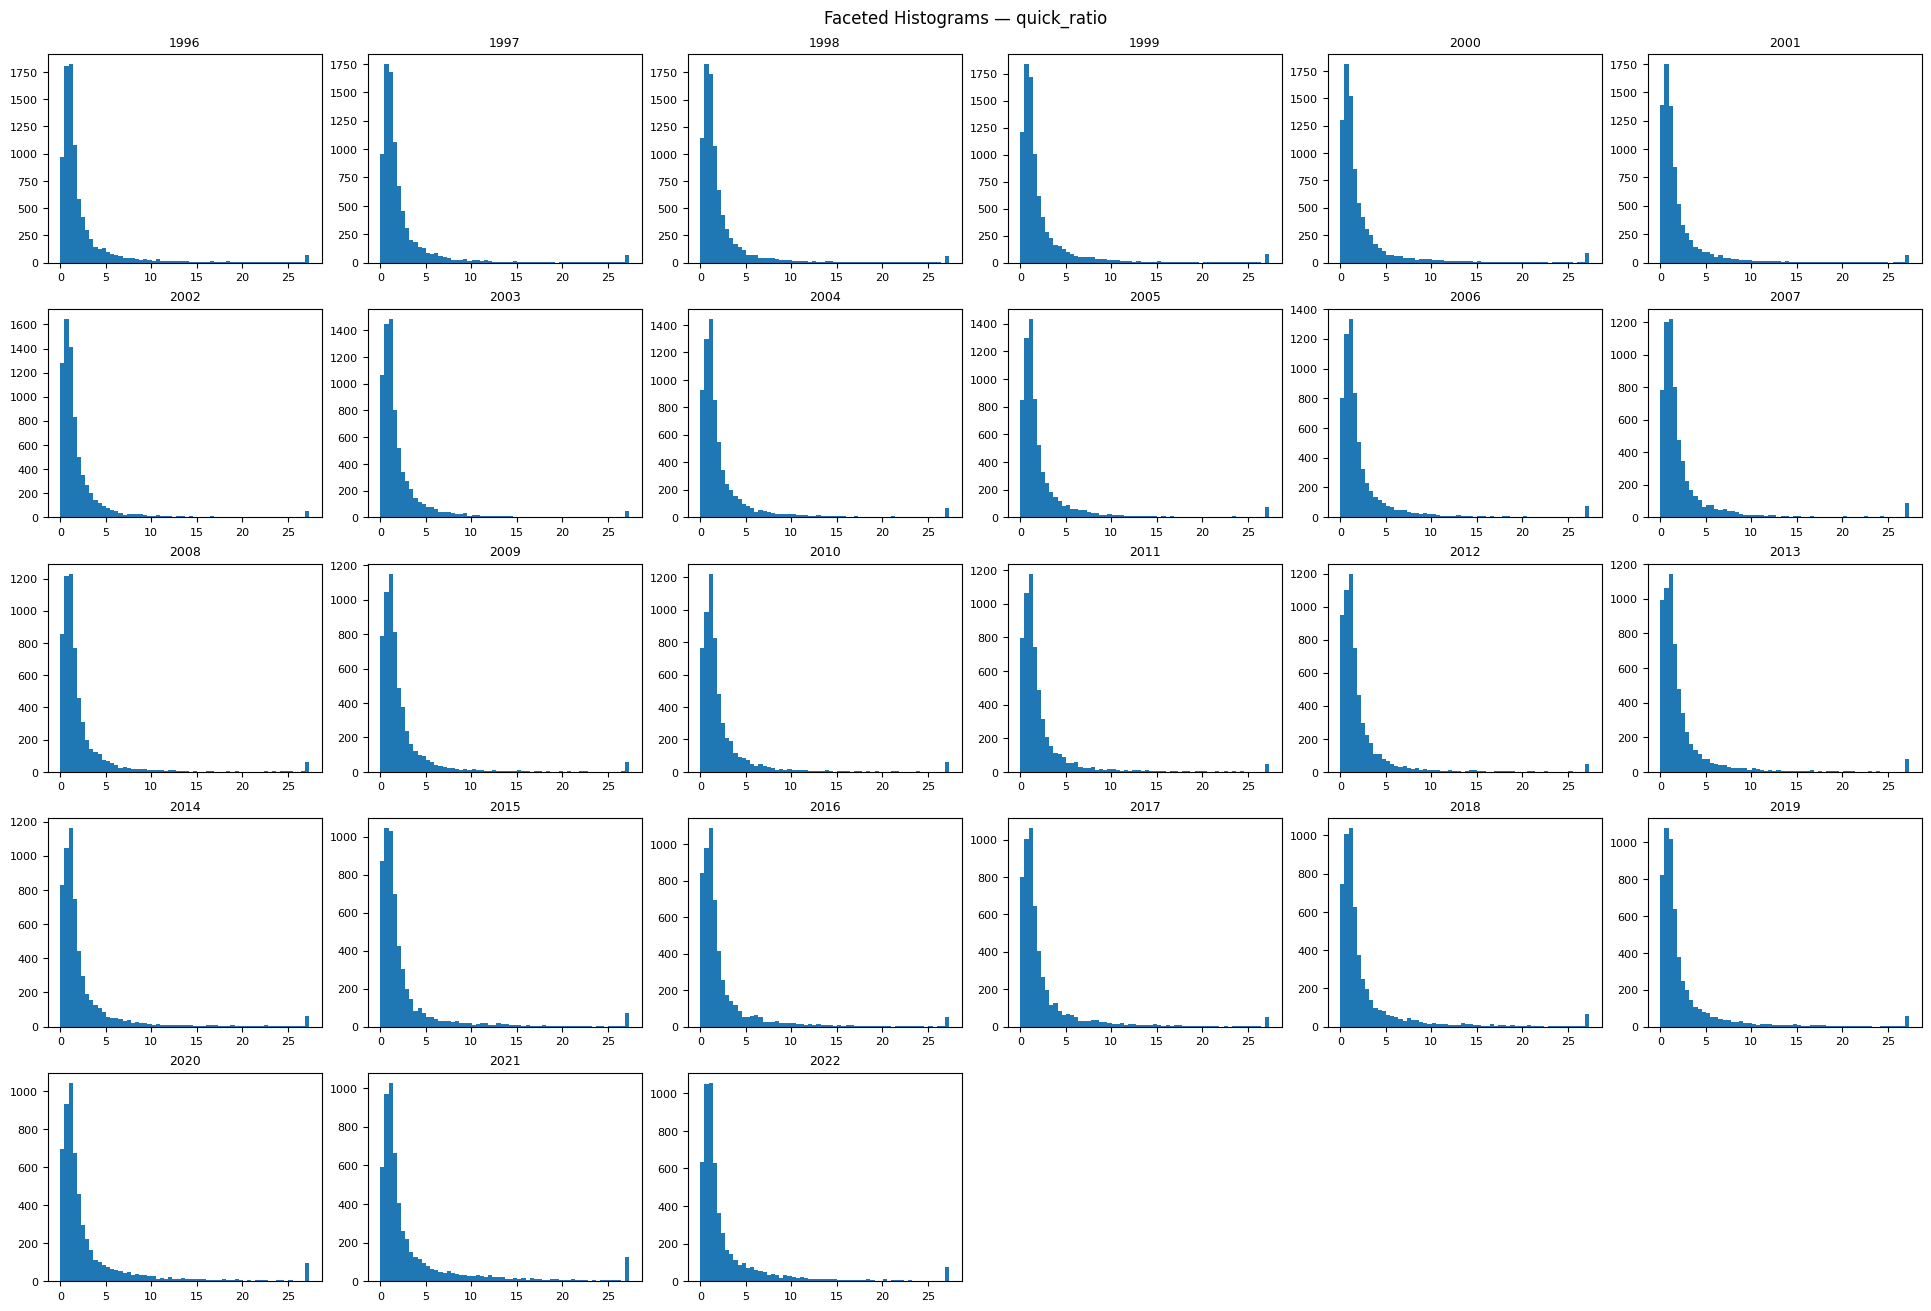

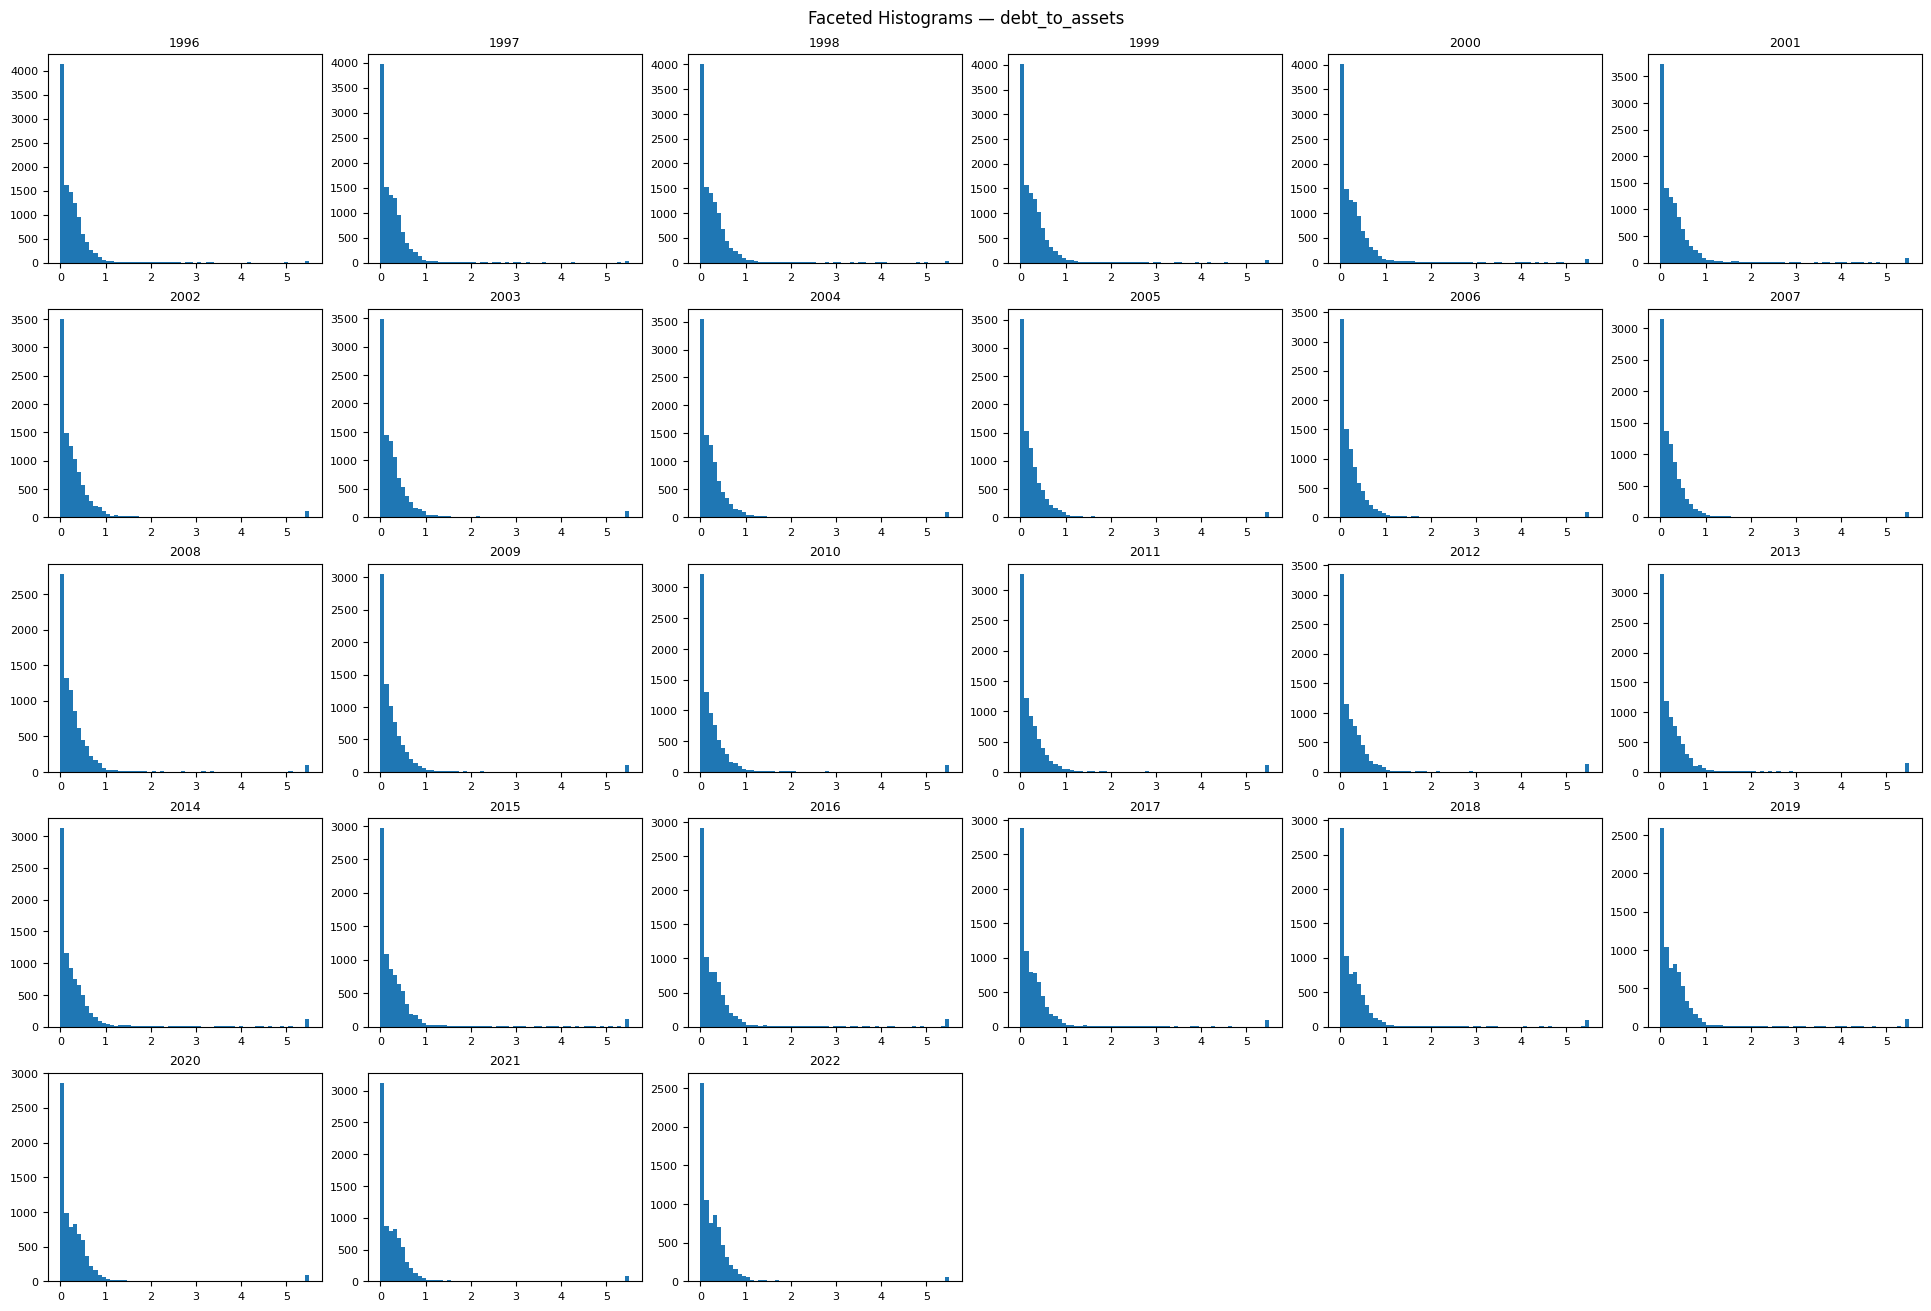

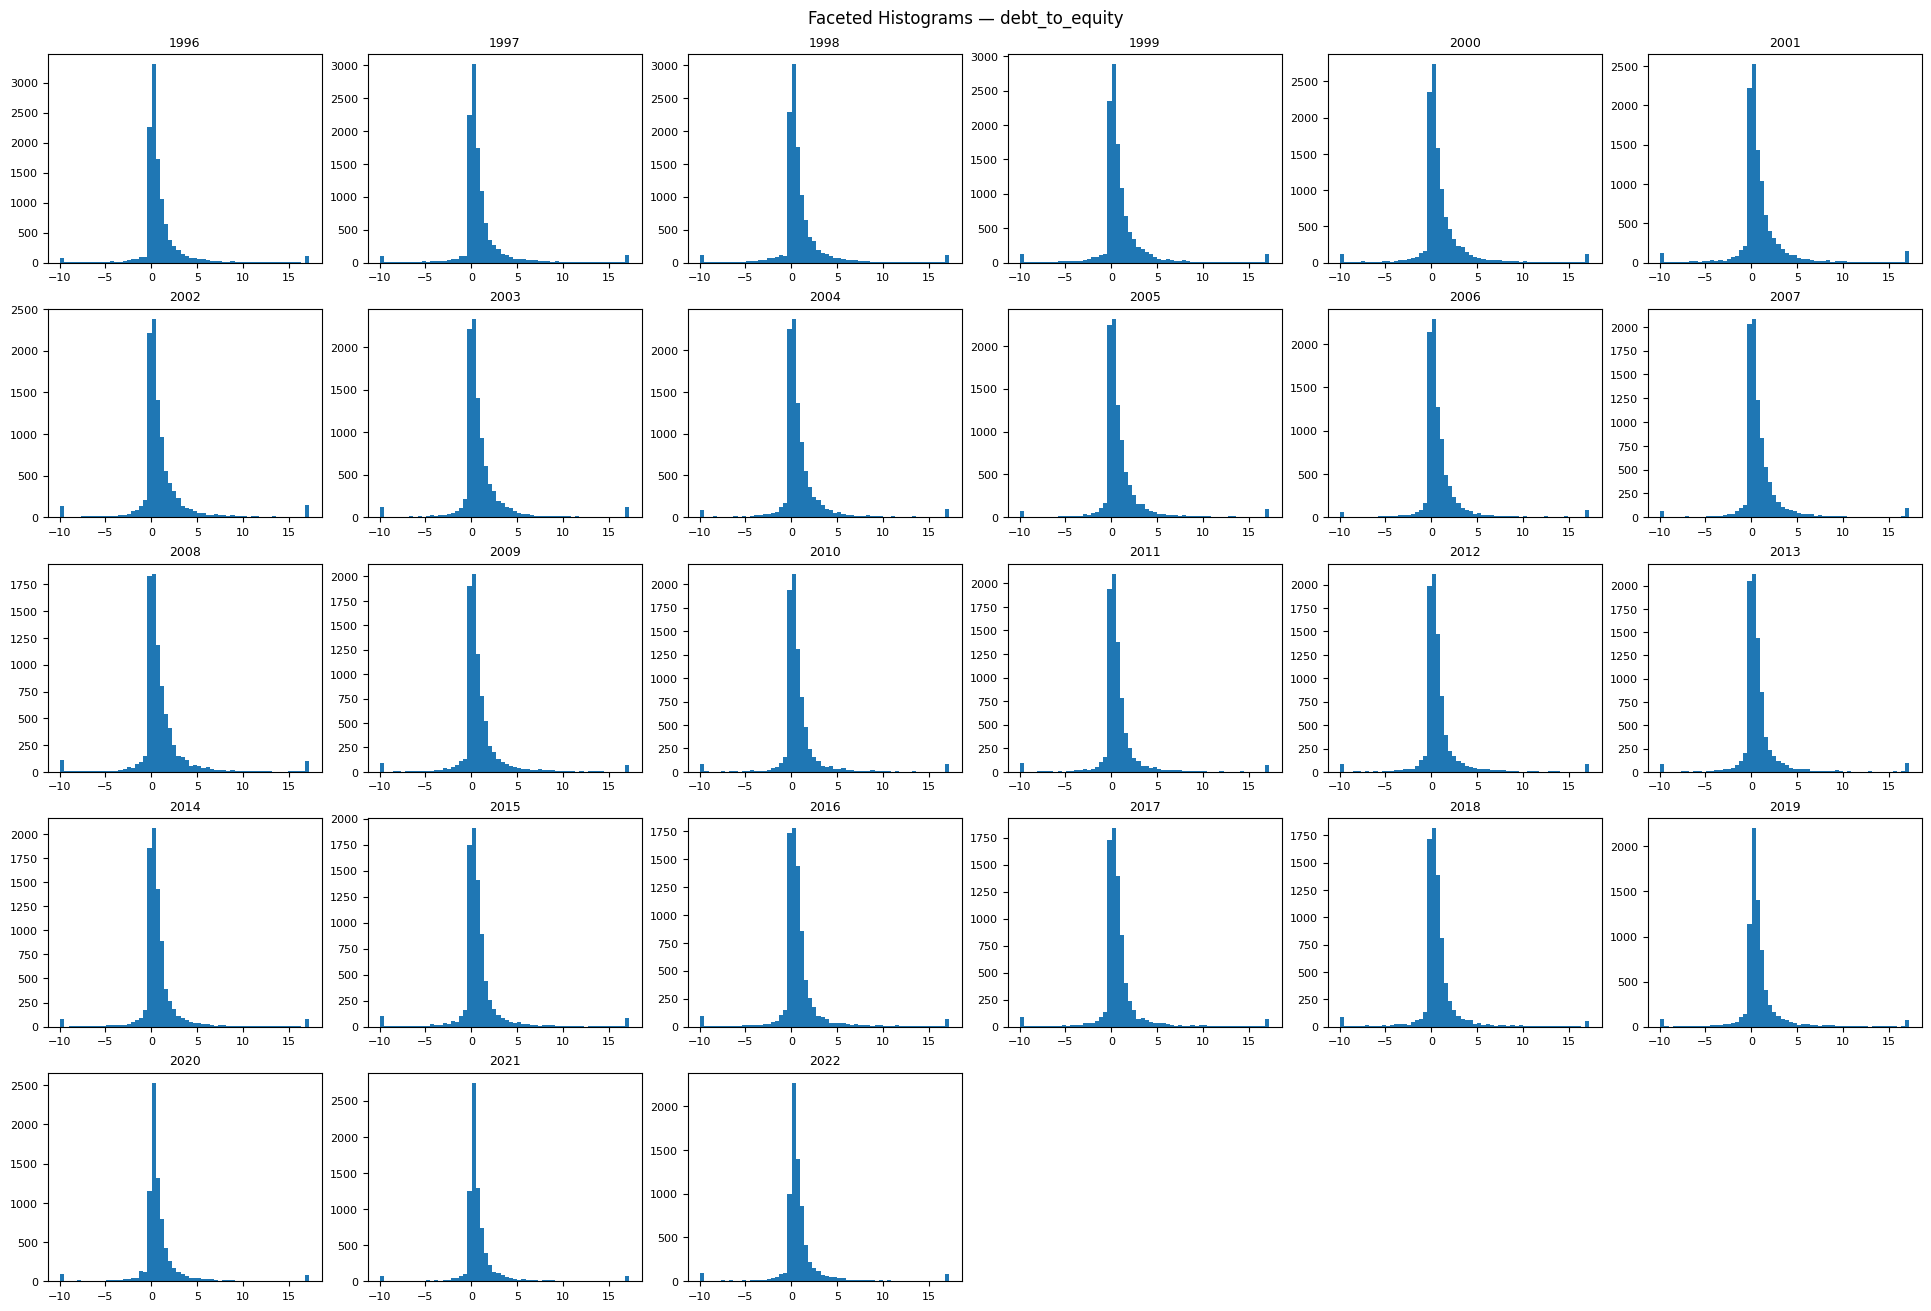

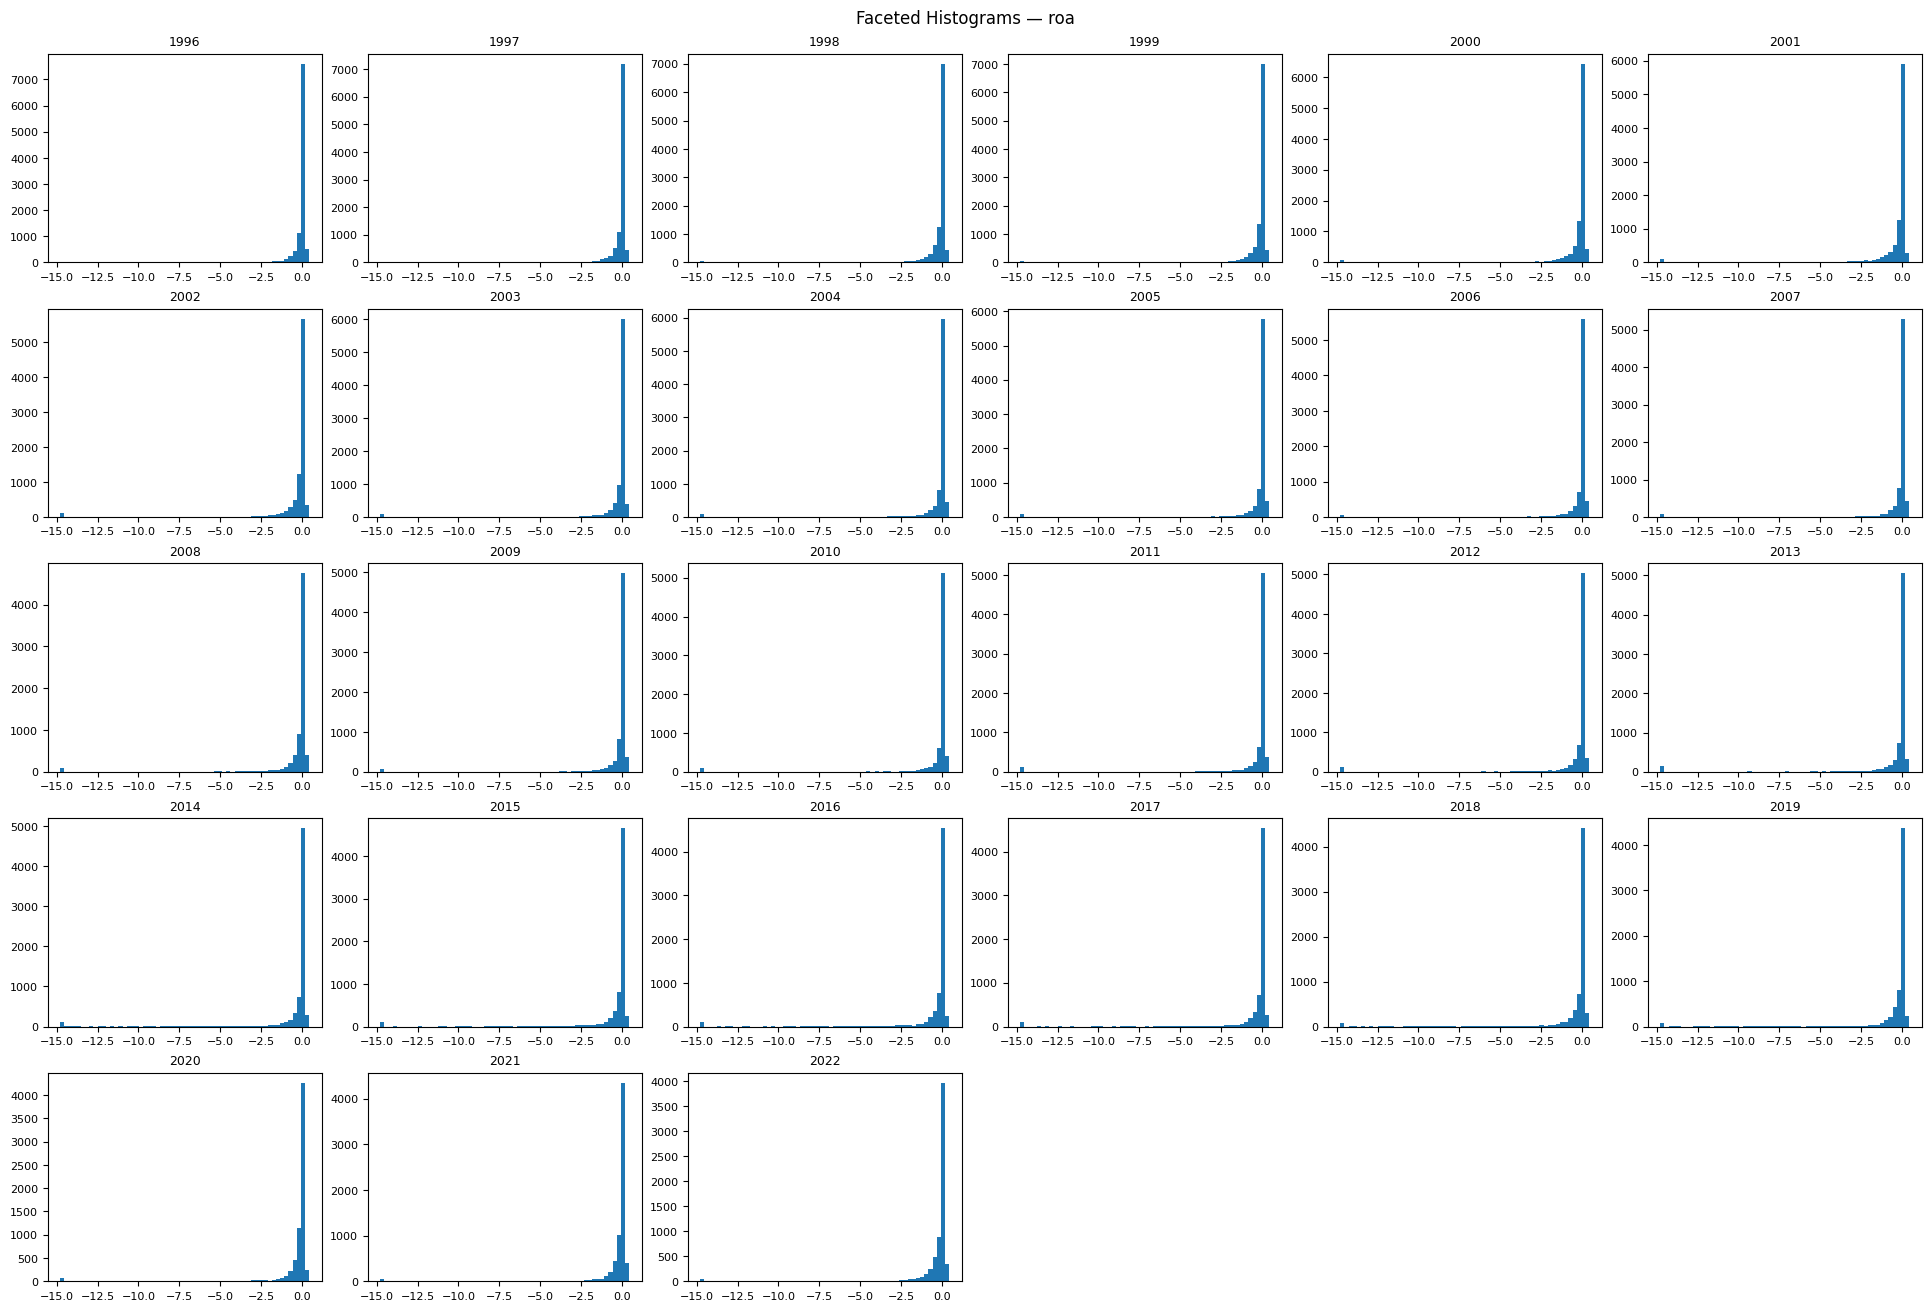

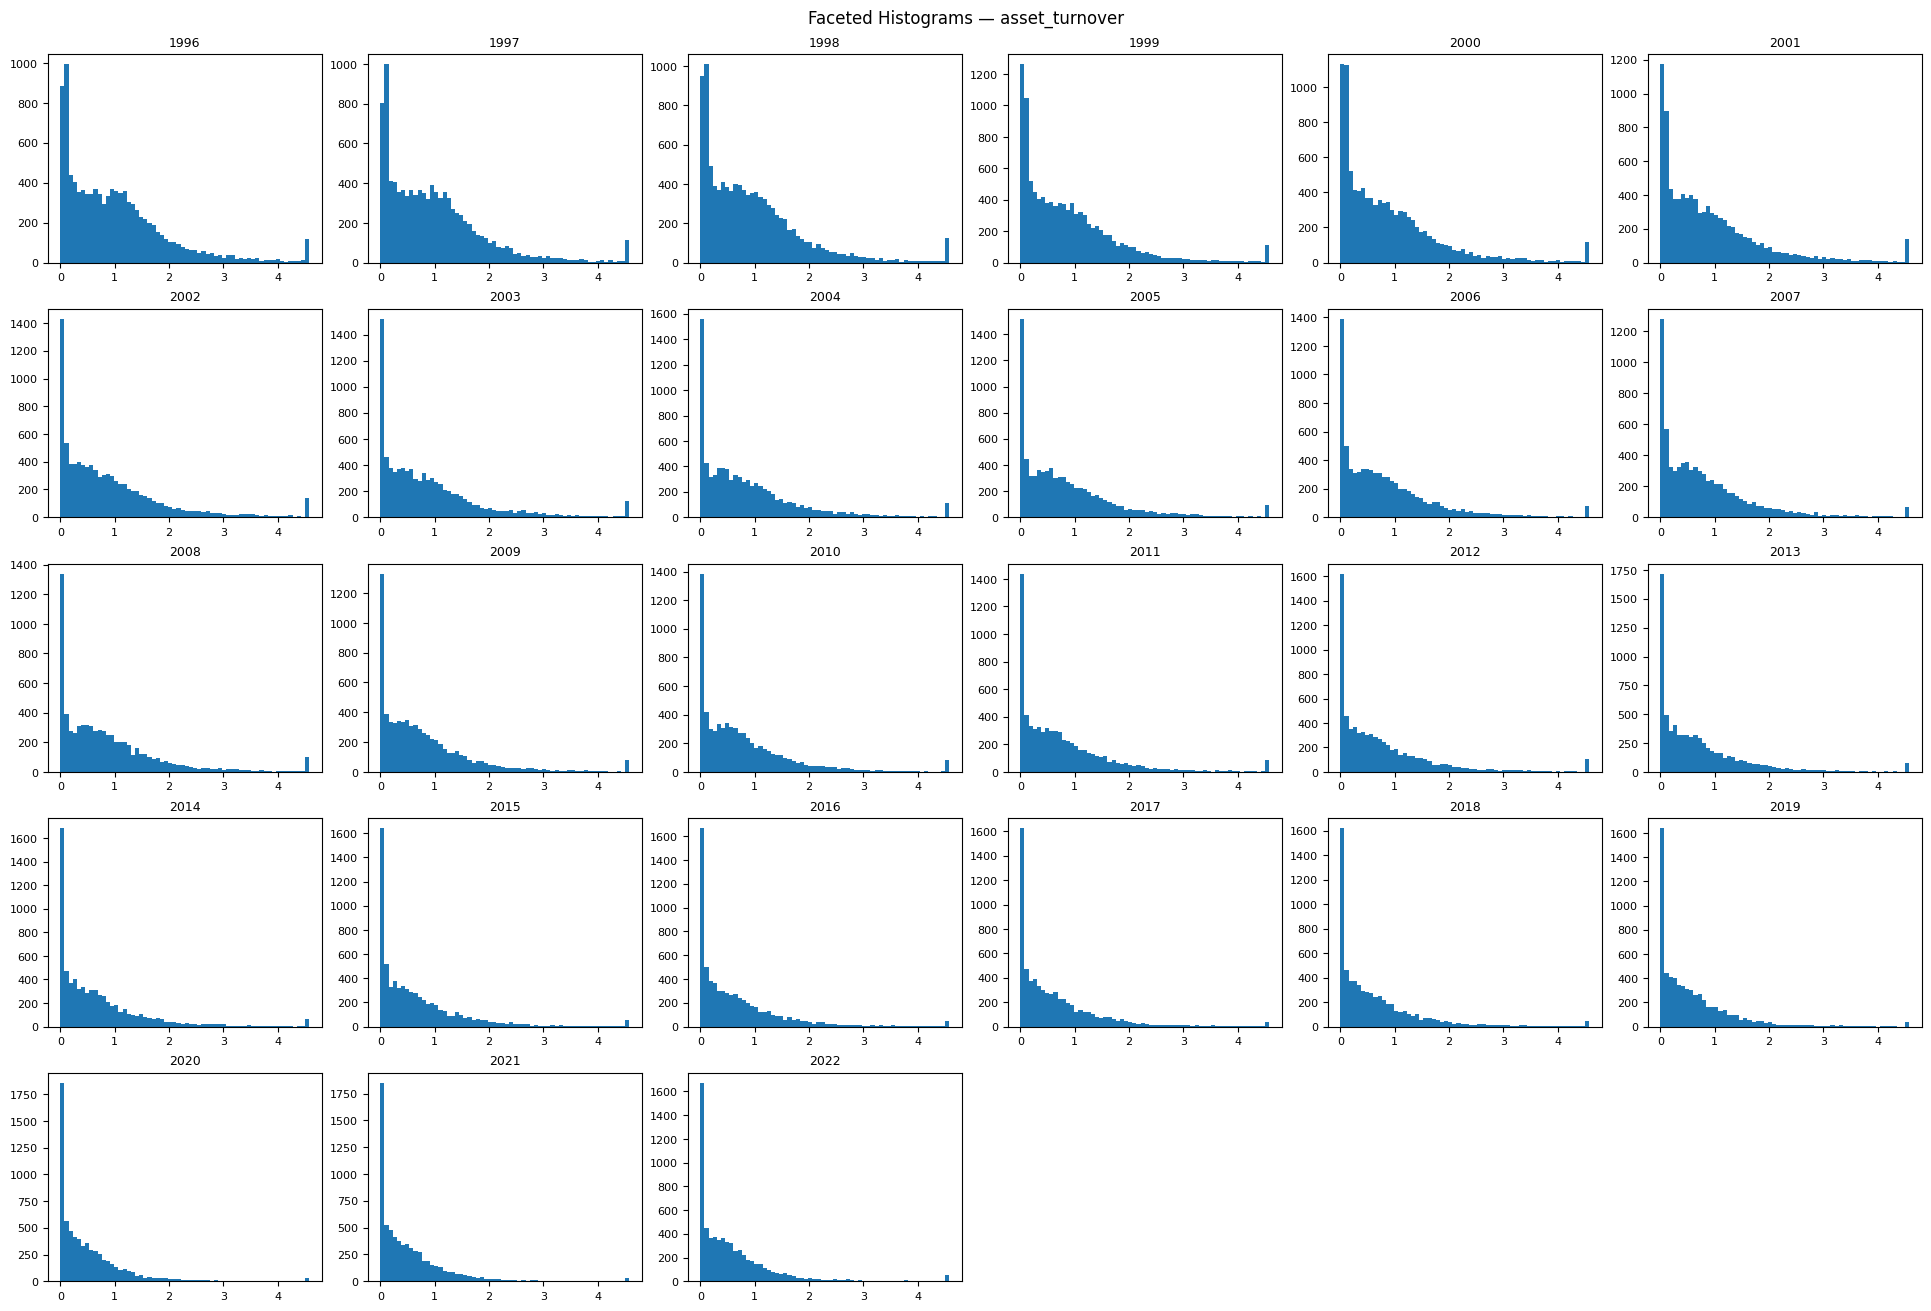

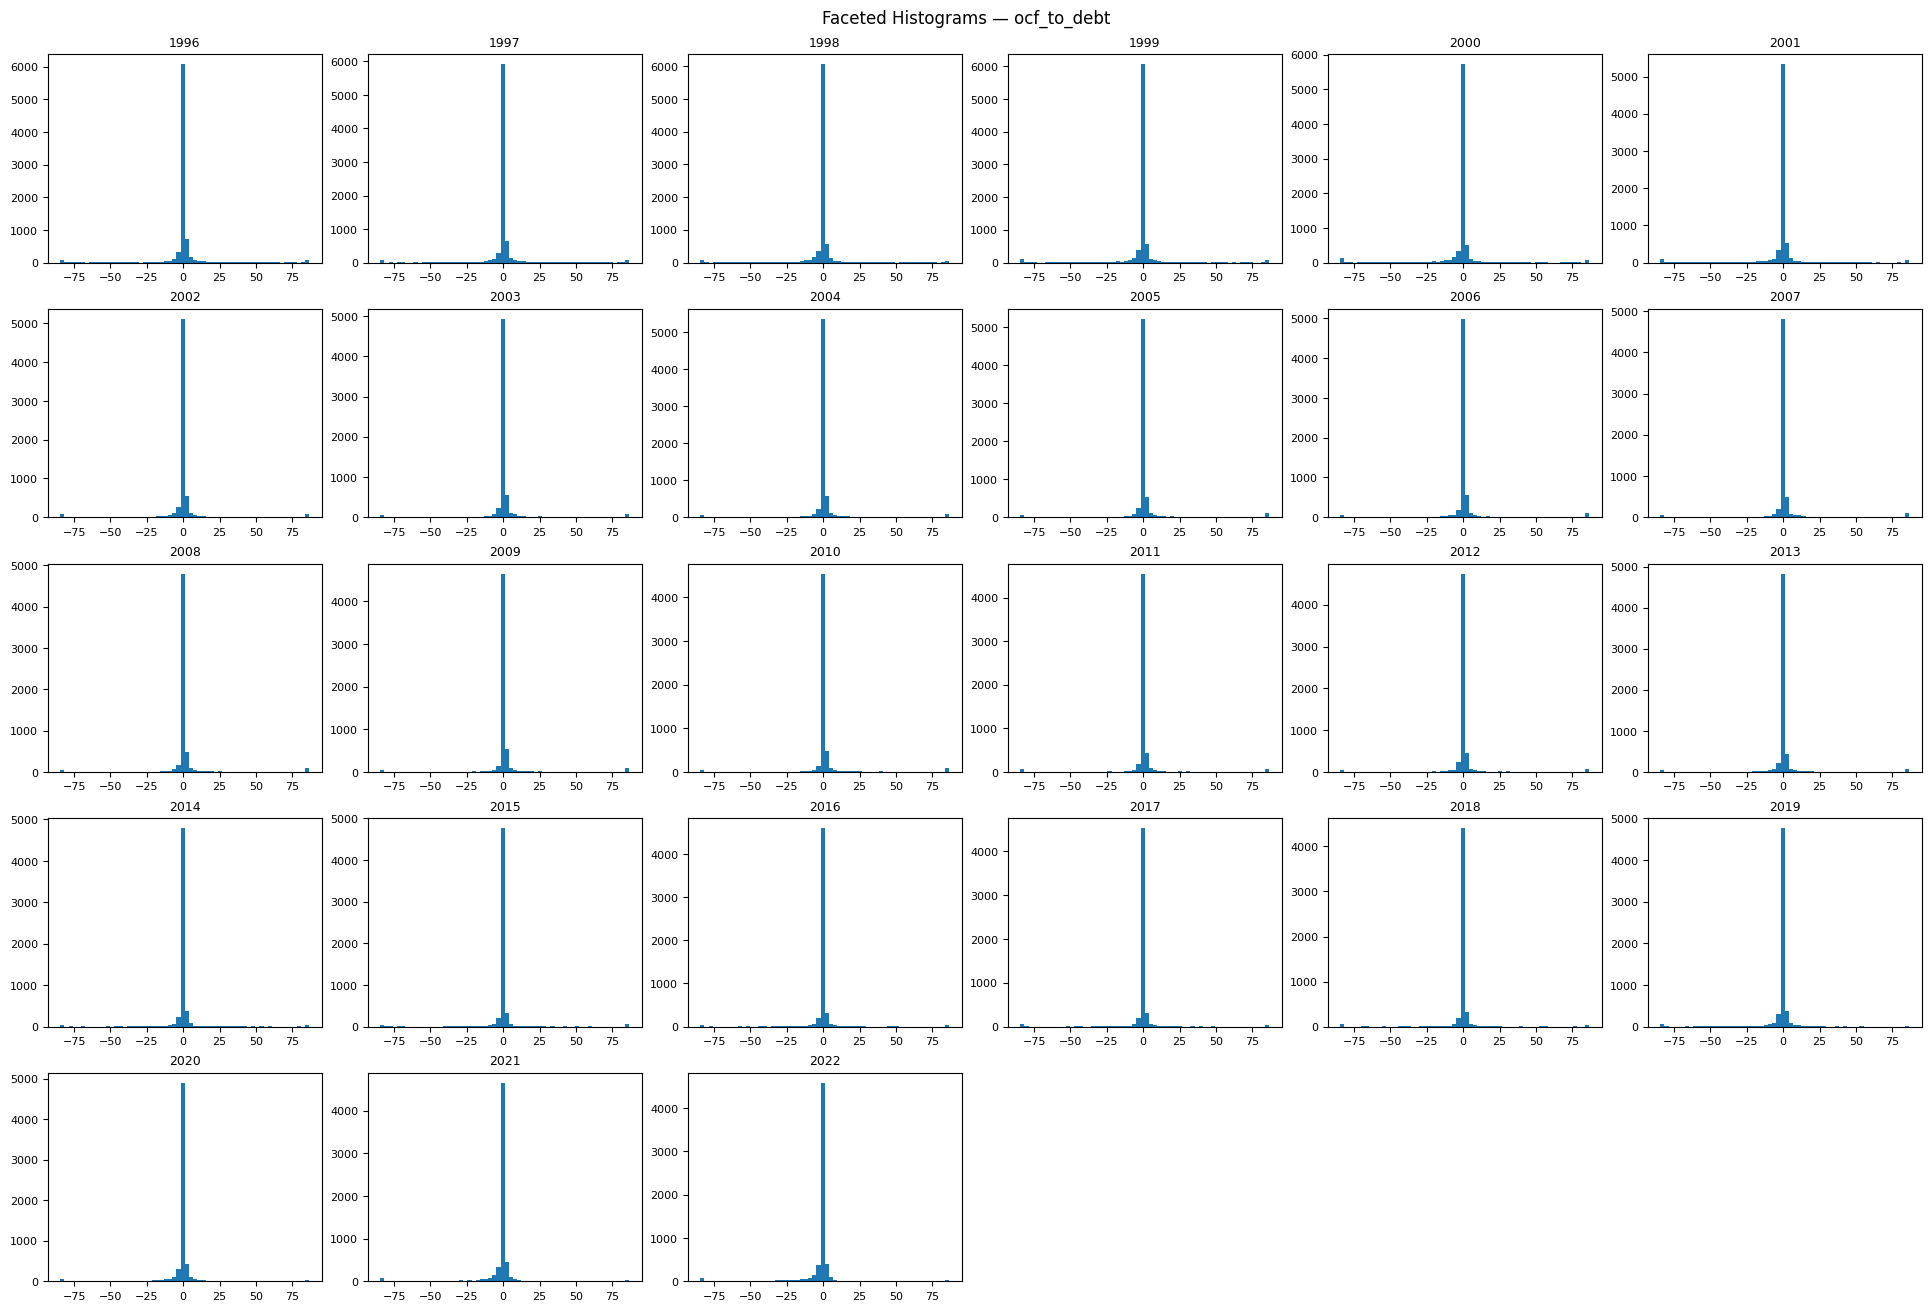

Saved figures in: ./data/facet_histograms
Saved per-year summaries in: ./data/facet_summaries


In [44]:
def freedman_diaconis_bins(x: np.ndarray) -> int:
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 10
    q25, q75 = np.percentile(x, [25, 75])
    iqr = q75 - q25
    if iqr == 0:
        return min(30, max(5, int(np.sqrt(x.size))))
    bw = 2 * iqr * (x.size ** (-1/3))
    if bw <= 0:
        return min(30, max(5, int(np.sqrt(x.size))))
    bins = int(np.ceil((x.max() - x.min()) / bw))
    return max(5, min(bins, 60))

def facet_histograms(
    df: pd.DataFrame,
    feature: str,
    years: list[int],
    max_cols: int = 6,
    clip_quantiles: tuple[float,float] = (0.01, 0.99),
    fixed_bins: int | None = None,
    log_positive_only: bool = False,
    save: bool = True,
    show: bool = True,
):
    data = df[[ "FYEAR", feature ]].dropna()
    if data.empty:
        print(f"[skip] {feature}: no data")
        return

    vals = data[feature].to_numpy()
    
    if clip_quantiles is not None:
        lo, hi = np.nanquantile(vals, clip_quantiles)
        data[feature] = data[feature].clip(lower=lo, upper=hi)

    use_log = False
    if log_positive_only:
        x = data[feature].to_numpy()
        if np.all(np.isfinite(x)) and np.nanmin(x) > 0:
            data[feature] = np.log1p(x)
            use_log = True
    
    x_for_bins = data[feature].to_numpy()
    bins = fixed_bins if fixed_bins is not None else freedman_diaconis_bins(x_for_bins)
    
    n = len(years)
    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.6*nrows), constrained_layout=True)
    axes = np.array(axes).reshape(nrows, ncols)

    for i, y in enumerate(years):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        yr_vals = data.loc[data["FYEAR"] == y, feature].dropna().to_numpy()
        if yr_vals.size == 0:
            ax.axis("off")
            continue
        ax.hist(yr_vals, bins=bins)
        ax.set_title(f"{y}", fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    for j in range(i+1, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    transform_note = " (log1p)" if use_log else ""
    fig.suptitle(f"Faceted Histograms — {feature}{transform_note}", fontsize=12)

    if save:
        fname = feature.replace("/", "_")
        out_path = os.path.join(OUT_DIR, f"facet_{fname}.png")
        plt.savefig(out_path, dpi=150)
    if show:
        plt.show()
    else:
        plt.close(fig)

for col in feature_cols:
    facet_histograms(
        df_feats,
        col,
        years=years,
        max_cols=6,                   
        clip_quantiles=(0.01, 0.99),  
        fixed_bins=None,              
        log_positive_only=False,      
        save=True,
        show=True
    )

print(f"Saved figures in: {OUT_DIR}")

def per_year_summary(df, feature):
    x = df[["FYEAR", feature]].dropna()
    if x.empty:
        return None
    g = x.groupby("FYEAR")[feature]
    out = pd.DataFrame({
        "N": g.size(),
        "mean": g.mean(),
        "p25": g.quantile(0.25),
        "p50": g.median(),
        "p75": g.quantile(0.75),
        "std": g.std(),
        "skew": g.skew(),
        "min": g.min(),
        "max": g.max()
    }).reset_index()
    out.insert(2, "IQR", out["p75"] - out["p25"])
    return out

SUM_DIR = os.path.join(DATA_PATH, "facet_summaries")
os.makedirs(SUM_DIR, exist_ok=True)

for col in feature_cols:
    s = per_year_summary(df_feats, col)
    if s is not None:
        s.to_csv(os.path.join(SUM_DIR, f"summary_{col}.csv"), index=False)

print(f"Saved per-year summaries in: {SUM_DIR}")

## Big picture

- **Persistent right-skew:** Most variables have a large mass near the low end with long right tails → many small/mid firms and a few giants
- **Crisis years widen spreads:** Around **2001**, **2008–09**, and **2020**, profitability/liquidity distributions fan out and left tails thicken → more dispersion in financial health
- **Ratios travel better than levels:** Ratios are more stable across time (less scale confounding); levels stay heavily size-driven every year

---

## Liquidity

- **cash (CHE)**  
  *Across time:* Slightly higher centers after 2008–09 and 2020 (cash hoarding)
  *Within year:* Very right-skewed; a handful of firms hold very large piles

- **short_term_investments (IVST)**  
  *Across time:* Same story as cash, with even more zeros in some years
  *Within year:* Mass at/near zero plus a thin right tail → redundant with cash for many firms

- **current_ratio** & **quick_ratio**  
  *Across time:* Nearly identical shapes; mild upward drifts post-recessions 
  *Within year:* Strong right-skew; most firms between ~1–3 with outliers far to the right

---

## Leverage / Solvency

- **total_liabilities (LT)**  
  *Across time:* Tail remains extremely long; overall shape stable (scale effect)
  *Within year:* Size-driven right tail; redundant with leverage ratios for modeling

- **debt_to_assets**  
  *Across time:* Stable hump near low-to-moderate leverage; tails widen in recession years
  *Within year:* Most firms cluster at conservative leverage; a few highly levered outliers

- **debt_to_equity**  
  *Across time:* Narrow core + very long tails; recession years show wider dispersion
  *Within year:* Extreme values (including negatives) appear when **equity is near/under zero**

- **interest_expense**  
  *Across time:* Highly skewed every year; spreads generally widen around recessions
  *Within year:* Many near zero; a small group bears very heavy interest loads

---

## Profitability

- **sales (SALE)** & **cogs (COGS)**  
  *Across time:* Shapes move in lockstep; both stay very right-skewed
  *Within year:* Near duplicates; better summarized via a **margin** than by carrying both

- **oibdp (operating inc. before D&A)**  
  *Across time:* Right-skew persists; spread widens in downturns
  *Within year:* Size-driven; a few very large outliers

- **net_income**  
  *Across time:* Left tail thickens in 2001, 2008–09, 2020 → more losses
  *Within year:* Tall central spike around small positives with a meaningful negative tail

- **roa (NI/AT)**  
  *Across time:* Distribution shifts left in recessions (lower profitability), then re-centers
  *Within year:* Mass near modest positives; pronounced left tail for underperformers

---

## Efficiency / Activity

- **asset_turnover (SALE/AT)**  
  *Across time:* Broadly stable, with mild softening in later years for some cohorts
  *Within year:* Classic right-skew; most firms low-to-moderate, few very high (e.g., retail)

---

## Cash-flow Health

- **operating_cf (OANCF)**  
  *Across time:* Spread widens in downturns; more density near/under zero
  *Within year:* Right-skew with a non-trivial negative tail (cash burn)

- **capex (CAPX)**  
  *Across time:* Persistently right-skewed; some pullbacks visible around recessions
  *Within year:* Many firms invest modestly; a few invest at very large scale

- **ocf_to_debt (OANCF/(DLTT+DLC))**  
  *Across time:* Center tight around zero; left tail deepens in recessions (coverage strain)
  *Within year:* Most firms show low/positive coverage; a minority has very weak/negative coverage

---

## Working-capital Structure

- **accounts_receivable (RECT)**  
  *Across time:* Stable right-skew; mild broadening during slowdowns
  *Within year:* Many small values; a few very large issuers dominate the tail

- **inventory (INVT)**  
  *Across time:* Similar to receivables; some widening around downturns (stock build or write-downs)
  *Within year:* Small-value cluster plus a thin, very long right tail

- **ppe_net (PPENT)**  
  *Across time:* Persistently heavy right tail; shape fairly constant
  *Within year:* Capital-intensive giants dominate the far right

- **shareholders_equity (SEQ)**  
  *Across time:* Right-skewed with occasional accumulation near low/negative values in crises
  *Within year:* Most firms modest equity; a few very large; negative-equity cases appear

- **dividends (DV/DVC)**  
  *Across time:* Mass at zero increases around recessions (cuts/omissions), then recovers
  *Within year:* Clear zero-inflation; paying firms sit on a thin right tail

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [46]:
OUT_FILE  = os.path.join(DATA_PATH, "scaled_features_1996_2022.parquet")

df = pd.read_csv(IN_FILE)
id_cols = [c for c in ["GVKEY","FYEAR"] if c in df.columns]

feature_cols = [
    "cash","short_term_investments","accounts_receivable","inventory","ppe_net",
    "total_liabilities","shareholders_equity","operating_cf","capex","dividends",
    "sales","cogs","oibdp","net_income","interest_expense",
    "current_ratio","quick_ratio","debt_to_assets","debt_to_equity","roa","asset_turnover",
    "ocf_to_debt"
]
feature_cols = [c for c in feature_cols if c in df.columns]  
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce")

In [47]:
class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper
        self.q_lo_ = None
        self.q_hi_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.q_lo_ = X.quantile(self.lower, numeric_only=True)
        self.q_hi_ = X.quantile(self.upper, numeric_only=True)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        return X.clip(self.q_lo_, self.q_hi_, axis=1).to_numpy()

log_std_cols   = []   
robust_cols    = []   
minmax_cols    = []   

for col in feature_cols:
    x = df[col].dropna()
    if x.empty:
        continue
    mn, sk = x.min(), x.skew()

    if col in ["debt_to_assets"]:
        minmax_cols.append(col)
        continue

    if mn >= 0 and (sk >= 1.0):
        log_std_cols.append(col)
    else:
        robust_cols.append(col)

print("log+standardize:", log_std_cols)
print("robust scale   :", robust_cols)
print("minmax (0-1)   :", minmax_cols)

log_std_pipe = Pipeline([
    ("clip", QuantileClipper(0.01, 0.99)),
    ("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("std", StandardScaler())
])

robust_pipe = Pipeline([
    ("clip", QuantileClipper(0.01, 0.99)),
    ("rob", RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25, 75)))
])

minmax_pipe = Pipeline([
    ("clip", QuantileClipper(0.01, 0.99)),
    ("mm", MinMaxScaler(feature_range=(0, 1)))
])

ct = ColumnTransformer(
    transformers=[
        ("logstd", log_std_pipe, log_std_cols),
        ("robust", robust_pipe, robust_cols),
        ("minmax", minmax_pipe, minmax_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0
)

X_scaled = ct.fit_transform(df[log_std_cols + robust_cols + minmax_cols])

ordered = log_std_cols + robust_cols + minmax_cols
scaled_cols = [f"{c}__scaled" for c in ordered]
scaled_df = pd.DataFrame(X_scaled, columns=scaled_cols, index=df.index)

out_df = pd.concat([df[id_cols], scaled_df], axis=1) if id_cols else scaled_df
out_df.to_parquet(OUT_FILE, index=False)
print("Saved:", OUT_FILE)

log+standardize: ['inventory', 'ppe_net', 'total_liabilities']
robust scale   : ['cash', 'short_term_investments', 'accounts_receivable', 'shareholders_equity', 'operating_cf', 'capex', 'dividends', 'sales', 'cogs', 'oibdp', 'net_income', 'interest_expense', 'current_ratio', 'quick_ratio', 'debt_to_equity', 'roa', 'asset_turnover', 'ocf_to_debt']
minmax (0-1)   : ['debt_to_assets']


/opt/homebrew/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Saved: ./data/scaled_features_1996_2022.parquet


In [62]:
OUT_FILE  = os.path.join(DATA_PATH, "selected_features_1996_2022_with_usrec.csv")

RECESSION_YEARS = {2001, 2008, 2009, 2020}

df = pd.read_csv(IN_FILE)
df["FYEAR"] = pd.to_numeric(df["FYEAR"], errors="coerce").astype("Int64")
df["USREC"] = df["FYEAR"].isin(RECESSION_YEARS).astype("int")

df.to_csv(OUT_FILE, index=False)
print("Saved:", OUT_FILE)
df.head()

Saved: ./data/selected_features_1996_2022_with_usrec.csv


,GVKEY,FYEAR,cash,short_term_investments,accounts_receivable,inventory,ppe_net,total_liabilities,shareholders_equity,operating_cf,...,net_income,interest_expense,current_ratio,quick_ratio,debt_to_assets,debt_to_equity,roa,asset_turnover,ocf_to_debt,USREC
0,1004,1996,51.705,0.0,122.944,217.239,71.108,260.325,269.259,9.531,...,23.025,10.786,4.141787,1.968984,0.223368,0.439324,0.043478,1.112813,0.080572,0
1,1004,1997,17.222,0.0,163.359,263.425,82.905,369.709,300.850,22.823,...,35.657,14.494,3.140505,1.374306,0.265071,0.590813,0.053175,1.166375,0.128402,0
2,1004,1998,8.250,0.0,164.302,304.499,104.012,400.595,326.035,28.525,...,41.671,18.567,2.927575,1.173407,0.249589,0.556256,0.057348,1.263416,0.157285,0
3,1004,1999,1.241,0.0,128.348,336.018,110.003,401.483,339.515,10.051,...,35.163,23.431,3.120983,1.069792,0.279030,0.608989,0.047454,1.382369,0.048612,0
4,1004,2000,13.809,0.0,115.187,320.590,108.907,361.642,340.212,46.093,...,18.531,21.887,3.874697,1.317995,0.275896,0.569172,0.026403,1.245637,0.238036,0


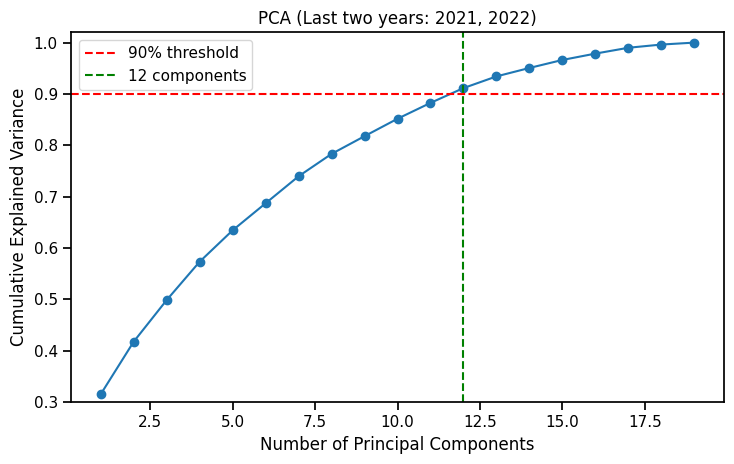

[PCA] Components for ≥90% variance: 12  (saved ./data/as3_figs/pca_cumulative.png)


In [64]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = [
    "cash","accounts_receivable","inventory","ppe_net","total_liabilities","shareholders_equity",
    "operating_cf","capex","dividends","sales","oibdp","net_income","interest_expense",
    "quick_ratio","debt_to_assets","debt_to_equity","roa","asset_turnover","ocf_to_debt"
]
features = [c for c in features if c in df.columns]
df[features] = df[features].apply(pd.to_numeric, errors="coerce")

last_two = sorted(df["FYEAR"].dropna().unique())[-2:]
d2 = df[df["FYEAR"].isin(last_two)].copy()

pos_cols = [c for c in features if pd.to_numeric(d2[c], errors="coerce").dropna().min() >= 0]
for c in pos_cols:
    d2[c] = np.log1p(d2[c])

X = d2[features]
X = SimpleImputer(strategy="median").fit_transform(X)
X = StandardScaler().fit_transform(X)

pca = PCA().fit(X)
expl = pca.explained_variance_ratio_
cum  = np.cumsum(expl)
k90  = int(np.searchsorted(cum, 0.90) + 1)

plt.figure(figsize=(7.5,4.8))
plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
plt.axhline(0.90, ls="--", color="red", label="90% threshold")
plt.axvline(k90, ls="--", color="green", label=f"{k90} components")
plt.title(f"PCA (Last two years: {last_two[0]}, {last_two[1]})")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.ylim(0.3, 1.02)
plt.legend()
plt.tight_layout()
pca_fig = os.path.join(OUT_DIR, "pca_cumulative.png")
plt.savefig(pca_fig, dpi=150)
plt.show()
print(f"[PCA] Components for ≥90% variance: {k90}  (saved {pca_fig})")

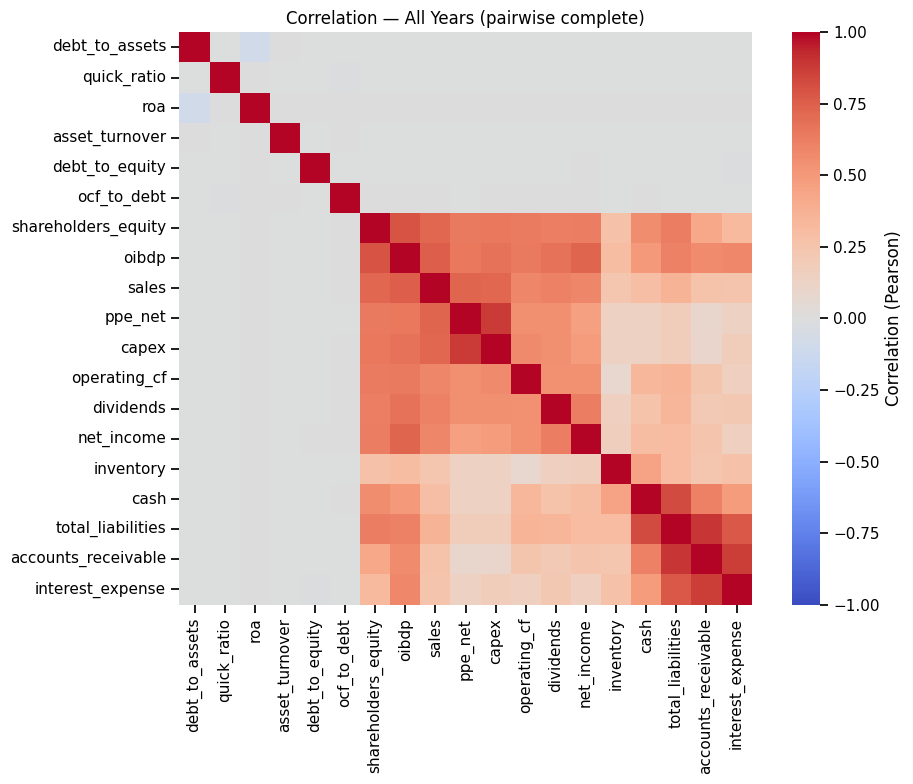

Saved: ./data/as3_figs/corr_heatmap_overall.png


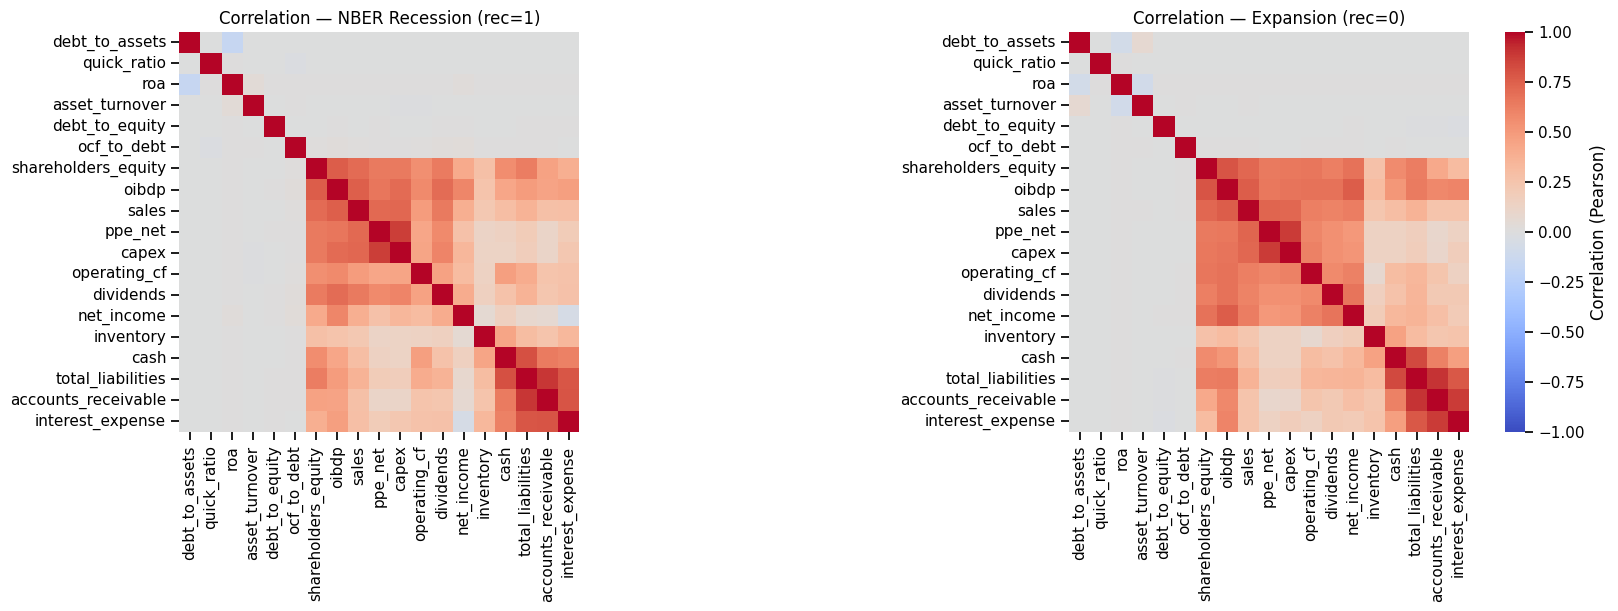

Saved: ./data/as3_figs/corr_heatmap_rec_vs_non.png


In [63]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

DATA_PATH = "./data"
IN_FILE   = os.path.join(DATA_PATH, "selected_features_1996_2022_with_usrec.csv")
OUT_DIR   = os.path.join(DATA_PATH, "as3_figs")
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_FILE)

features = [
    "cash","accounts_receivable","inventory","ppe_net","total_liabilities","shareholders_equity",
    "operating_cf","capex","dividends","sales","oibdp","net_income","interest_expense",
    "quick_ratio","debt_to_assets","debt_to_equity","roa","asset_turnover","ocf_to_debt"
]
features = [c for c in features if c in df.columns]
df[features] = df[features].apply(pd.to_numeric, errors="coerce")

corr_all = df[features].corr(method="pearson", min_periods=50)
try:
    from scipy.cluster.hierarchy import linkage, leaves_list
    Z = linkage(corr_all.fillna(0), method="average")
    order = leaves_list(Z)
    ordered = corr_all.columns[order]
    corr_plot = corr_all.loc[ordered, ordered]
except Exception:
    ordered = corr_all.columns
    corr_plot = corr_all

plt.figure(figsize=(10,8))
sns.heatmap(corr_plot, vmin=-1, vmax=1, center=0, cmap="coolwarm", square=True,
            cbar_kws={"label":"Correlation (Pearson)"})
plt.title("Correlation — All Years (pairwise complete)")
plt.tight_layout()
overall_png = os.path.join(OUT_DIR, "corr_heatmap_overall.png")
plt.savefig(overall_png, dpi=150)
plt.show()
print("Saved:", overall_png)

corr_rec = df.loc[df["USREC"] == 1, features].corr(method="pearson", min_periods=50)
corr_non = df.loc[df["USREC"] == 0, features].corr(method="pearson", min_periods=50)
corr_rec, corr_non = corr_rec.loc[ordered, ordered], corr_non.loc[ordered, ordered]

fig, axes = plt.subplots(1, 2, figsize=(16,6), constrained_layout=True)
sns.heatmap(corr_rec, vmin=-1, vmax=1, center=0, cmap="coolwarm", square=True,
            cbar=False, ax=axes[0], xticklabels=True, yticklabels=True)
axes[0].set_title("Correlation — NBER Recession (rec=1)")

sns.heatmap(corr_non, vmin=-1, vmax=1, center=0, cmap="coolwarm", square=True,
            cbar=True, ax=axes[1], xticklabels=True, yticklabels=True,
            cbar_kws={"label":"Correlation (Pearson)"})
axes[1].set_title("Correlation — Expansion (rec=0)")

rec_non_png = os.path.join(OUT_DIR, "corr_heatmap_rec_vs_non.png")
plt.savefig(rec_non_png, dpi=150)
plt.show()
print("Saved:", rec_non_png)

## PCA — variance coverage (last two years)

**Answer:** **12** principal components are needed to reach **≥ 90%** cumulative variance (FYEAR **2021–2022**).  
For reference, the first 10 PCs explain **85.18%**.